
Processed: set1_Image_01_40x_bf_02_D_fascicle.png
Axons detected: 96

Axon 1:
  Center = (1235.00, 2136.00)
  Outer Radius = 3.2894 µm
  Inner Radius = 0.2040 µm
  Thickness = 3.0854 µm
  Diameter = 6.5788 µm
  Outer Area = 19.3838 µm²
  Inner Area = 0.0740 µm²
  Area Ratio = 0.0038

Axon 2:
  Center = (1330.10, 2114.17)
  Outer Radius = 2.9859 µm
  Inner Radius = 0.5627 µm
  Thickness = 2.4232 µm
  Diameter = 5.9719 µm
  Outer Area = 19.1988 µm²
  Inner Area = 0.5734 µm²
  Area Ratio = 0.0299

Axon 3:
  Center = (993.00, 2075.50)
  Outer Radius = 7.9665 µm
  Inner Radius = 0.1360 µm
  Thickness = 7.8305 µm
  Diameter = 15.9329 µm
  Outer Area = 50.3184 µm²
  Inner Area = 0.0370 µm²
  Area Ratio = 0.0007

Axon 4:
  Center = (1126.30, 2055.86)
  Outer Radius = 3.7091 µm
  Inner Radius = 0.6415 µm
  Thickness = 3.0675 µm
  Diameter = 7.4181 µm
  Outer Area = 26.0609 µm²
  Inner Area = 0.4901 µm²
  Area Ratio = 0.0188

Axon 5:
  Center = (216.50, 2060.00)
  Outer Radius = 8.8382 µm
  Inn

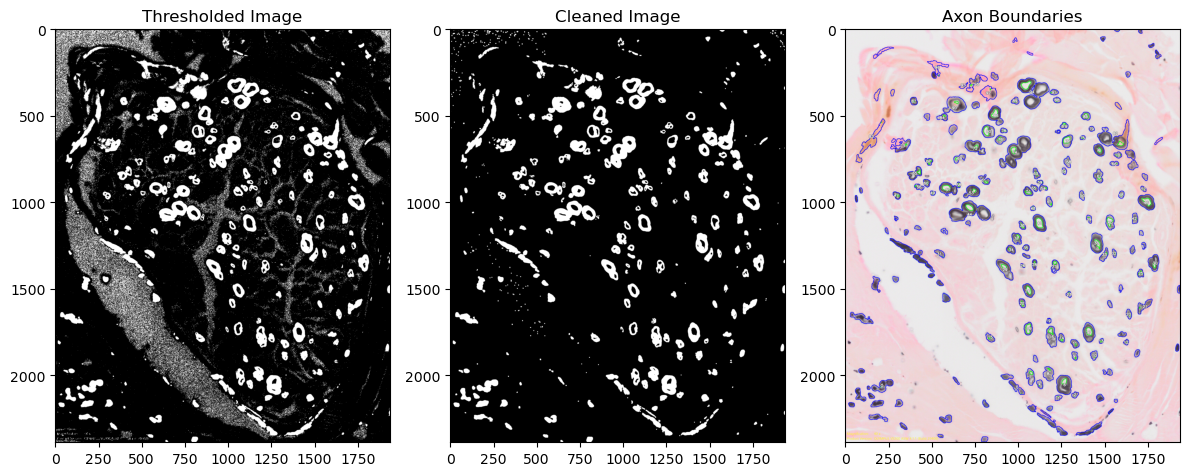


✅ Image processed and saved to 'C:\Users\sanje\Downloads\AF'


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Input and output paths for single image
image_path = r"C:\Users\sanje\Downloads\nerveBiopsyData\nerveBiopsyData\set1_Image_01_40x_bf_02_D_fascicle.png"
output_folder = r"C:\Users\sanje\Downloads\AF"
os.makedirs(output_folder, exist_ok=True)

# Scale factor
scale_factor = 0.136

def darken_and_sharpen(image):
    # Darken the image
    darkened = cv2.convertScaleAbs(image, alpha=1.1, beta=-10)
    # Sharpen the image
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    sharpened = cv2.filter2D(darkened, -1, sharpen_kernel)
    return sharpened

def filter_dark_regions(image):
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)

    # Threshold for dark regions (L channel low)
    dark_mask = cv2.inRange(L, 0, 250)  # You can tweak 110 if needed

    # Apply mask to keep only dark areas
    dark_filtered = cv2.bitwise_and(image, image, mask=dark_mask)
    return dark_filtered

def process_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = darken_and_sharpen(image)

    # Filter only dark shades (axons)
    image = filter_dark_regions(image)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Gaussian blur
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)

    # Otsu's thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological operations to clean small noise
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Find contours
    contours, hierarchy = cv2.findContours(cleaned, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    axon_data = []
    object_counter = 1
    min_contour_area = 320
    output_image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Draw on original image

    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area < min_contour_area:
            continue

        # Filter based on shape
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h if h != 0 else 0
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area if hull_area != 0 else 0

        # Reject long, skinny or fragmented shapes
        if aspect_ratio < 0.3 or aspect_ratio > 3.5 or solidity < 0.5:
            continue

        if hierarchy[0][i][3] == -1:
            (x_outer, y_outer), outer_radius = cv2.minEnclosingCircle(contour)
            cv2.drawContours(output_image, [contour], -1, (255, 0, 0), 2)

            largest_inner_contour = None
            max_inner_area = 0
            inner_radius = 0

            for j, inner_contour in enumerate(contours):
                if hierarchy[0][j][3] == i:
                    area = cv2.contourArea(inner_contour)
                    if area > max_inner_area:
                        max_inner_area = area
                        largest_inner_contour = inner_contour
                        (x_inner, y_inner), inner_radius = cv2.minEnclosingCircle(inner_contour)

            if largest_inner_contour is not None:
                cv2.drawContours(output_image, [largest_inner_contour], -1, (0, 255, 0), 2)

                outer_area_px = cv2.contourArea(contour)
                inner_area_px = cv2.contourArea(largest_inner_contour)
                outer_area_um2 = outer_area_px * (scale_factor ** 2)
                inner_area_um2 = inner_area_px * (scale_factor ** 2)
                area_ratio = inner_area_um2 / outer_area_um2 if outer_area_um2 != 0 else 0

                axon_data.append({
                    "axon_id": object_counter,
                    "outer_radius": outer_radius * scale_factor,
                    "inner_radius": inner_radius * scale_factor,
                    "thickness": (outer_radius - inner_radius) * scale_factor,
                    "diameter": (2 * outer_radius) * scale_factor,
                    "center": (x_outer, y_outer),
                    "outer_area": outer_area_um2,
                    "inner_area": inner_area_um2,
                    "area_ratio": area_ratio
                })

                # Labeling
                text = str(object_counter)
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.7
                thickness = 2
                (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, thickness)
                text_x = int(x_outer - text_width / 2)
                text_y = int(y_outer + text_height / 2)

                cv2.putText(output_image, text, (text_x, text_y), font, font_scale, (0, 0, 0), thickness + 2, cv2.LINE_AA)
                cv2.putText(output_image, text, (text_x, text_y), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

                object_counter += 1

    # Save output
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_folder, f"processed_{filename}")
    cv2.imwrite(output_path, output_image)

    print(f"\nProcessed: {filename}")
    print(f"Axons detected: {len(axon_data)}\n")

    for data in axon_data:
        print(f"Axon {data['axon_id']}:")
        print(f"  Center = ({data['center'][0]:.2f}, {data['center'][1]:.2f})")
        print(f"  Outer Radius = {data['outer_radius']:.4f} µm")
        print(f"  Inner Radius = {data['inner_radius']:.4f} µm")
        print(f"  Thickness = {data['thickness']:.4f} µm")
        print(f"  Diameter = {data['diameter']:.4f} µm")
        print(f"  Outer Area = {data['outer_area']:.4f} µm²")
        print(f"  Inner Area = {data['inner_area']:.4f} µm²")
        print(f"  Area Ratio = {data['area_ratio']:.4f}\n")

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Thresholded Image")
    plt.imshow(thresh, cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("Cleaned Image")
    plt.imshow(cleaned, cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Axon Boundaries")
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

    plt.tight_layout()
    plt.show()

# Run
process_image(image_path)
print(f"\n✅ Image processed and saved to '{output_folder}'")

#Loads an image and prepares an output folder.
#Darkens and sharpens the image to enhance axon visibility.
#Filters out only dark regions (likely axons).
#Converts to grayscale, enhances contrast, and reduces noise.
#Applies thresholding and morphological cleaning.
#Detects contours and filters out irrelevant ones based on shape.
#Identifies outer and inner axon boundaries.
#Calculates radii, thickness, diameter, and area in micrometers.
#Draws boundaries and labels on the image.
#Saves the result and prints axon measurements.
#Displays thresholded, cleaned, and final images for review.


Axon 1:
  Outer Center = (320.50, 1533.00)µm
  Inner Center = (322.50, 1522.50)µm
  Outer Radius = 8.3684 µm
  Inner Radius = 0.6451 µm
  Thickness = 7.7233 µm
  Diameter = 16.7369 µm
  Outer Area = 67.9173 µm²
  Inner Area = 0.8786 µm²
  Area Ratio = 0.0129

Axon 2:
  Outer Center = (728.50, 1481.50)µm
  Inner Center = (723.91, 1463.28)µm
  Outer Radius = 7.1481 µm
  Inner Radius = 3.7019 µm
  Thickness = 3.4462 µm
  Diameter = 14.2962 µm
  Outer Area = 76.3422 µm²
  Inner Area = 12.7622 µm²
  Area Ratio = 0.1672

Axon 3:
  Outer Center = (1339.00, 1418.50)µm
  Inner Center = (1330.00, 1445.50)µm
  Outer Radius = 9.5697 µm
  Inner Radius = 3.8784 µm
  Thickness = 5.6913 µm
  Diameter = 19.1393 µm
  Outer Area = 154.8393 µm²
  Inner Area = 25.6724 µm²
  Area Ratio = 0.1658

Axon 4:
  Outer Center = (1088.00, 1407.50)µm
  Inner Center = (1081.95, 1402.16)µm
  Outer Radius = 14.0576 µm
  Inner Radius = 9.6565 µm
  Thickness = 4.4011 µm
  Diameter = 28.1152 µm
  Outer Area = 416.1692 µm²

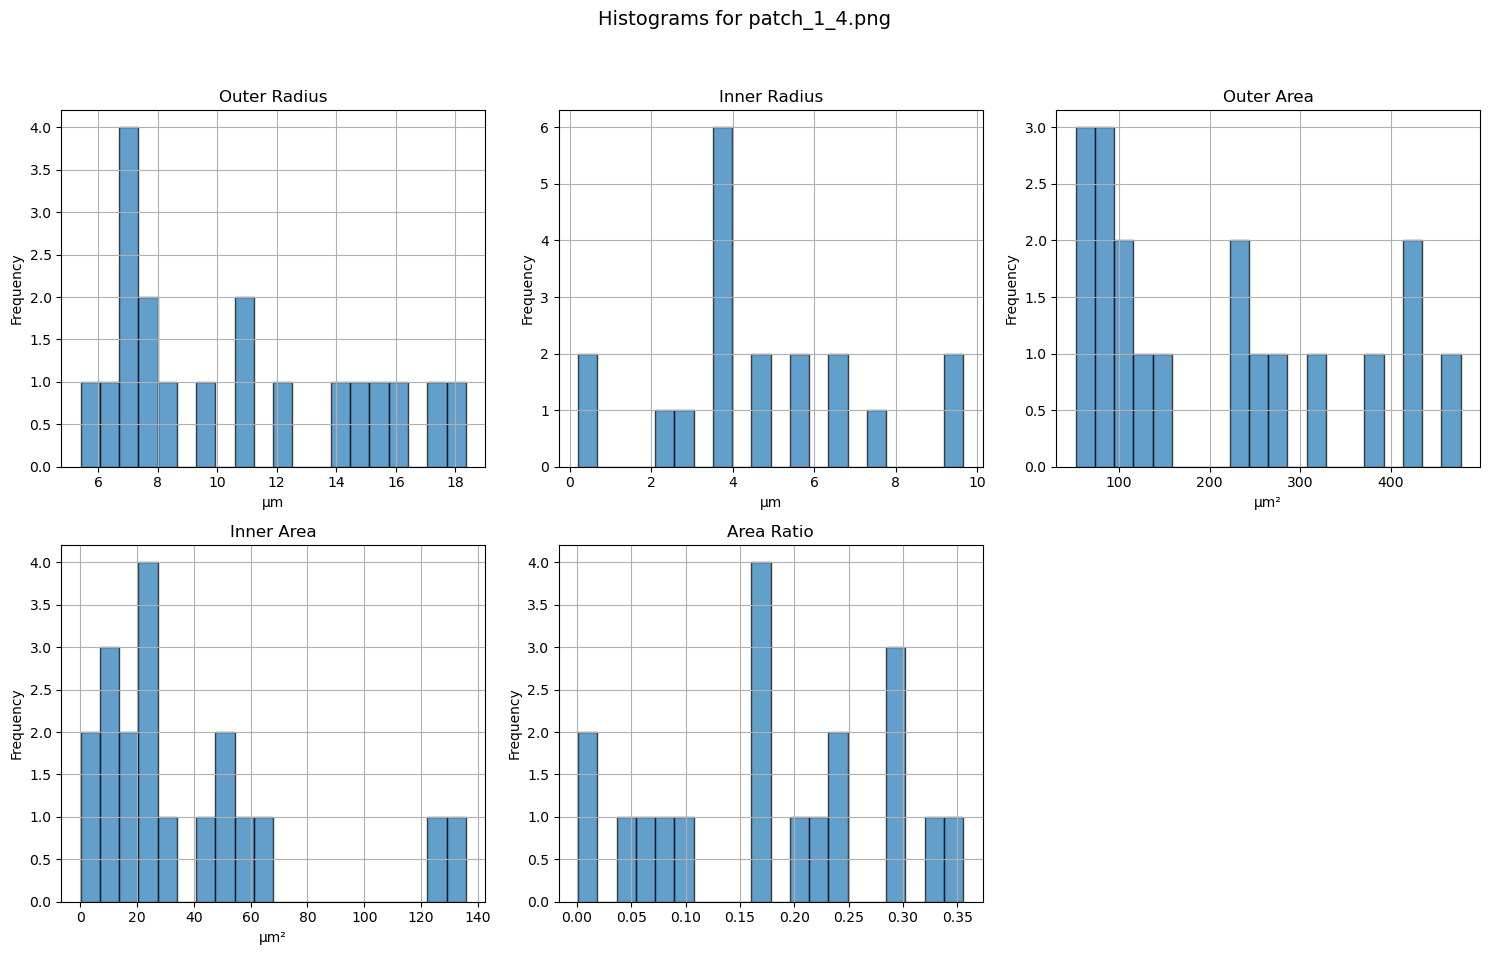

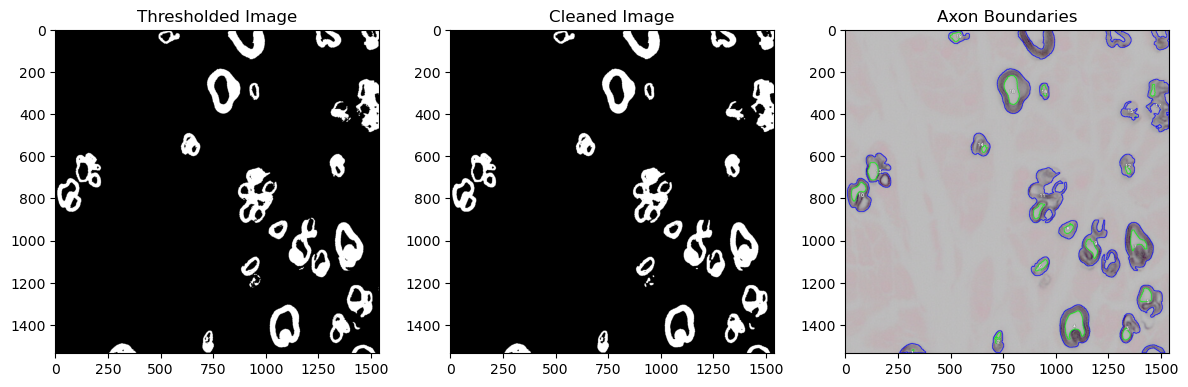


Axon 1:
  Outer Center = (806.00, 1406.00)µm
  Inner Center = (805.20, 1406.39)µm
  Outer Radius = 7.5293 µm
  Inner Radius = 5.2928 µm
  Thickness = 2.2365 µm
  Diameter = 15.0586 µm
  Outer Area = 119.8911 µm²
  Inner Area = 44.5384 µm²
  Area Ratio = 0.3715

Axon 2:
  Outer Center = (57.00, 1200.00)µm
  Inner Center = (77.84, 1191.91)µm
  Outer Radius = 11.9819 µm
  Inner Radius = 5.4919 µm
  Thickness = 6.4900 µm
  Diameter = 23.9638 µm
  Outer Area = 292.1813 µm²
  Inner Area = 52.3437 µm²
  Area Ratio = 0.1791

Axon 3:
  Outer Center = (1121.06, 1243.39)µm
  Inner Center = (1101.49, 1179.59)µm
  Outer Radius = 20.3064 µm
  Inner Radius = 7.9478 µm
  Thickness = 12.3587 µm
  Diameter = 40.6129 µm
  Outer Area = 542.5709 µm²
  Inner Area = 80.9015 µm²
  Area Ratio = 0.1491

Axon 4:
  Outer Center = (592.24, 1157.81)µm
  Inner Center = (586.00, 1174.00)µm
  Outer Radius = 17.4000 µm
  Inner Radius = 7.4552 µm
  Thickness = 9.9447 µm
  Diameter = 34.7999 µm
  Outer Area = 494.6755 µ

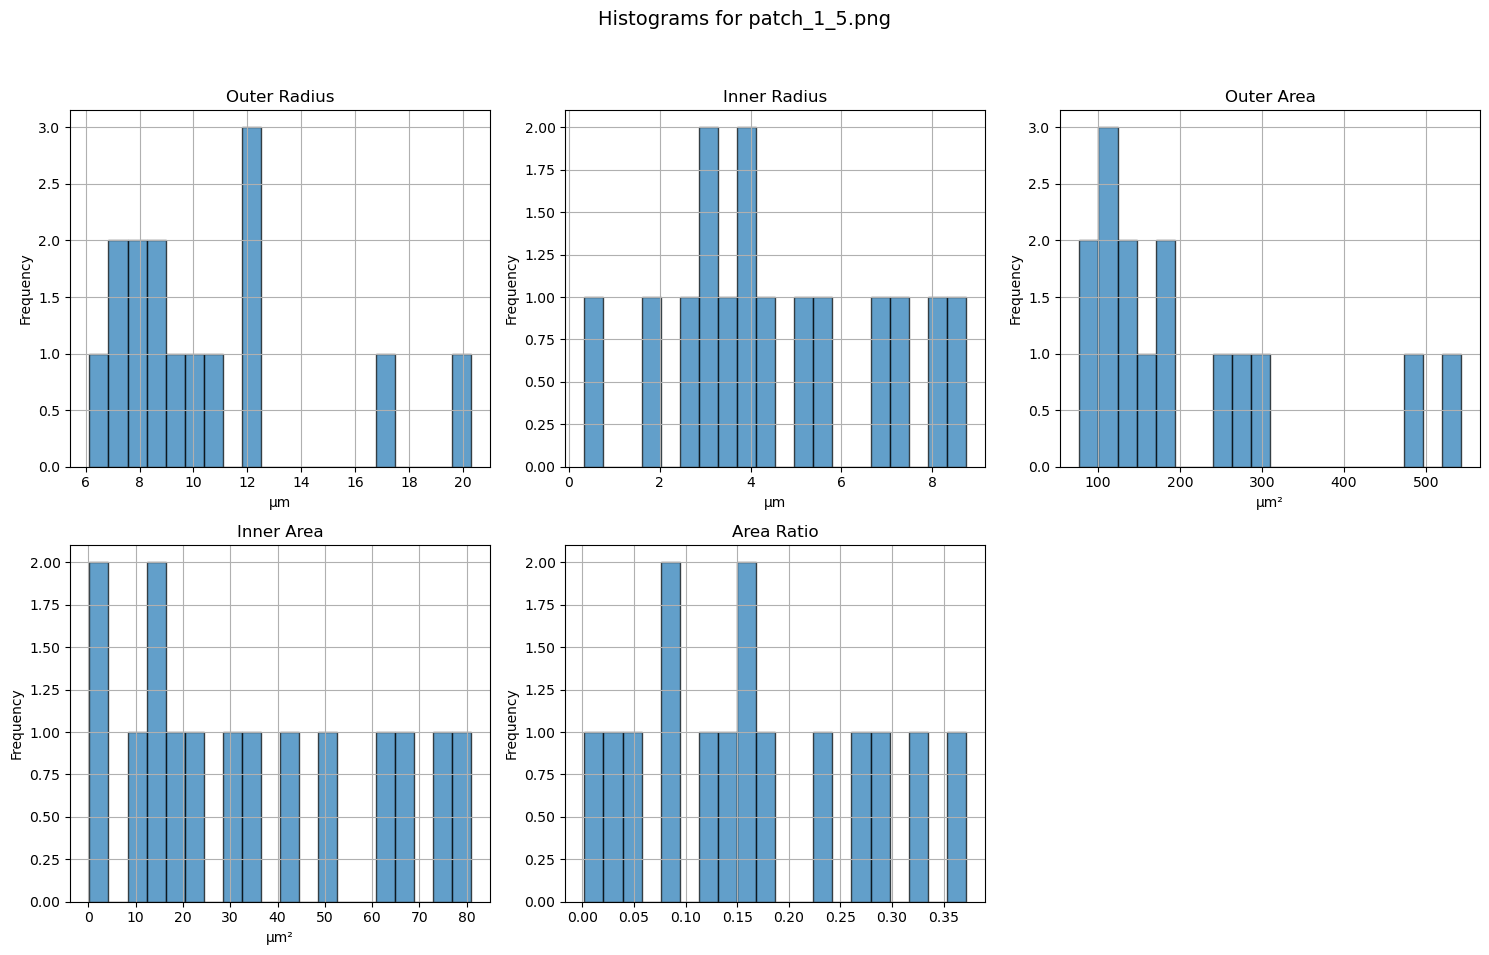

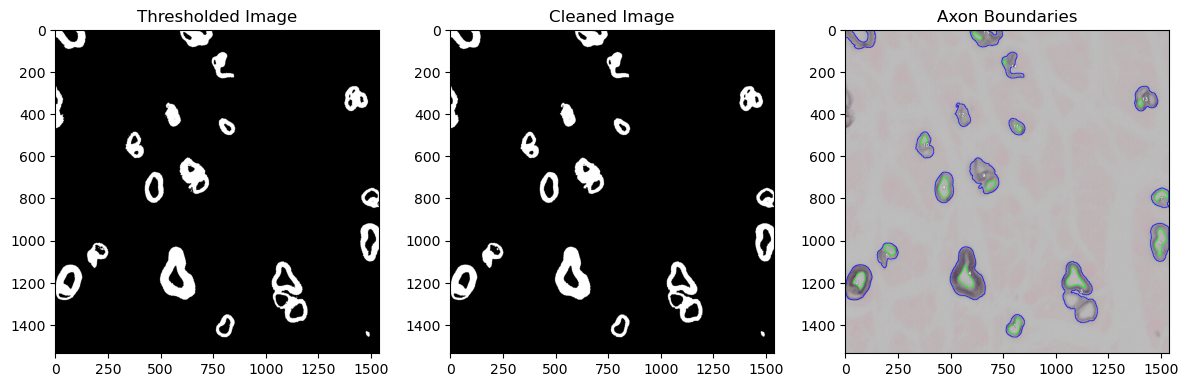


Axon 1:
  Outer Center = (753.71, 1460.44)µm
  Inner Center = (737.50, 1494.00)µm
  Outer Radius = 10.0423 µm
  Inner Radius = 3.5601 µm
  Thickness = 6.4821 µm
  Diameter = 20.0845 µm
  Outer Area = 168.2489 µm²
  Inner Area = 22.1212 µm²
  Area Ratio = 0.1315

Axon 2:
  Outer Center = (449.61, 1368.62)µm
  Inner Center = (447.00, 1375.50)µm
  Outer Radius = 9.5614 µm
  Inner Radius = 5.0159 µm
  Thickness = 4.5455 µm
  Diameter = 19.1228 µm
  Outer Area = 221.3139 µm²
  Inner Area = 48.4318 µm²
  Area Ratio = 0.2188

Axon 3:
  Outer Center = (224.31, 1309.67)µm
  Inner Center = (235.50, 1318.00)µm
  Outer Radius = 6.2676 µm
  Inner Radius = 3.8135 µm
  Thickness = 2.4542 µm
  Diameter = 12.5353 µm
  Outer Area = 89.6871 µm²
  Inner Area = 22.2969 µm²
  Area Ratio = 0.2486

Axon 4:
  Outer Center = (1097.50, 1227.50)µm
  Inner Center = (1082.50, 1276.00)µm
  Outer Radius = 13.5048 µm
  Inner Radius = 2.2233 µm
  Thickness = 11.2815 µm
  Diameter = 27.0096 µm
  Outer Area = 201.7174 µ

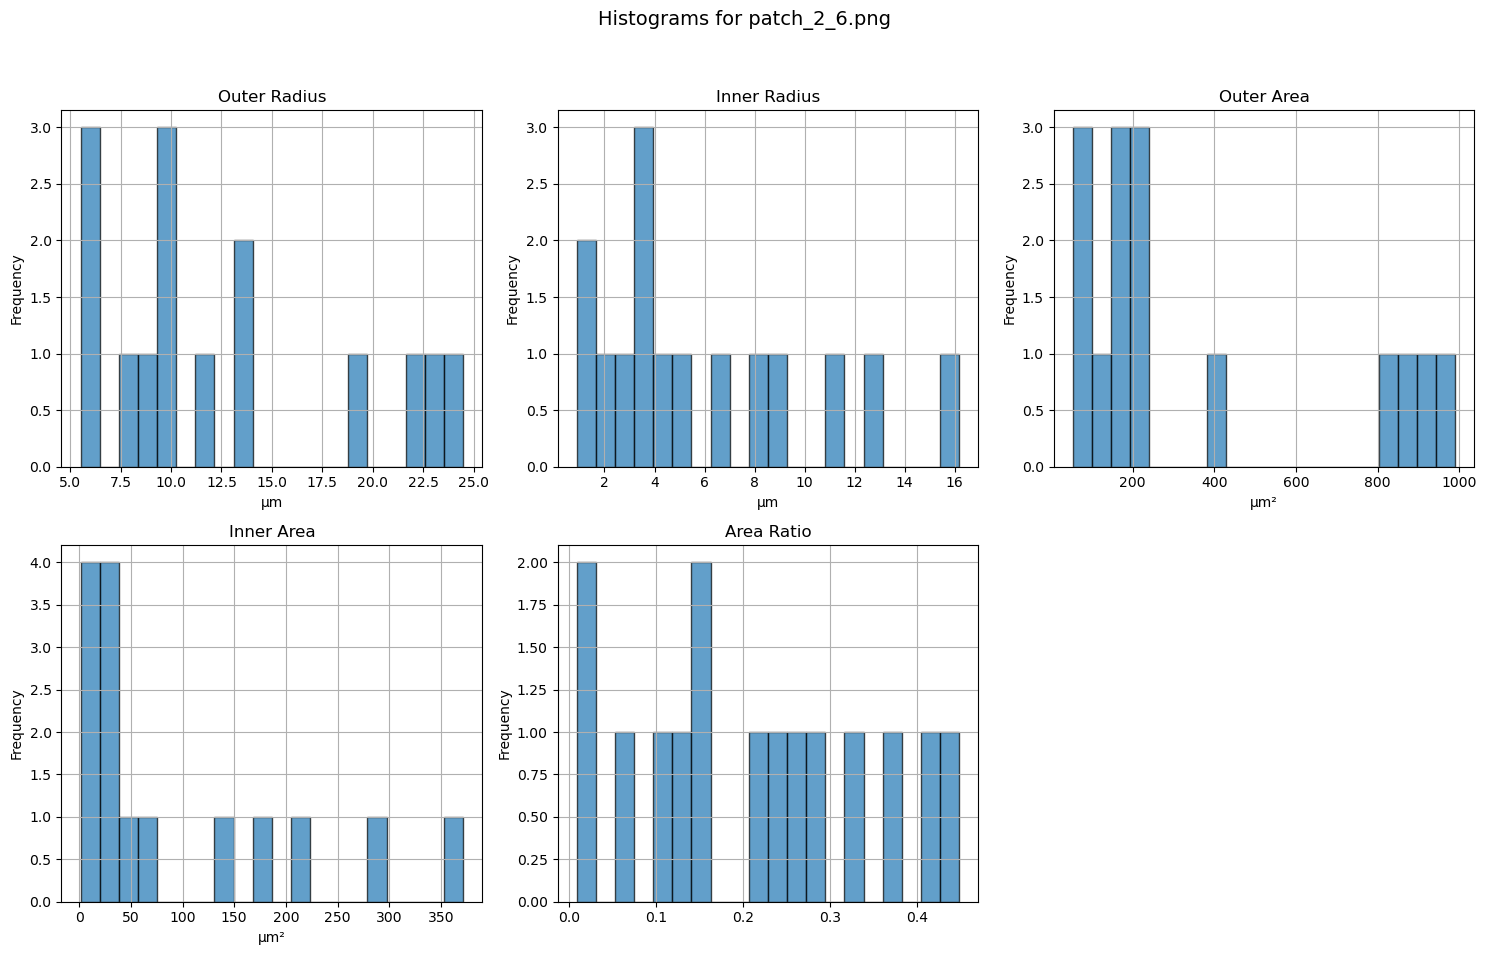

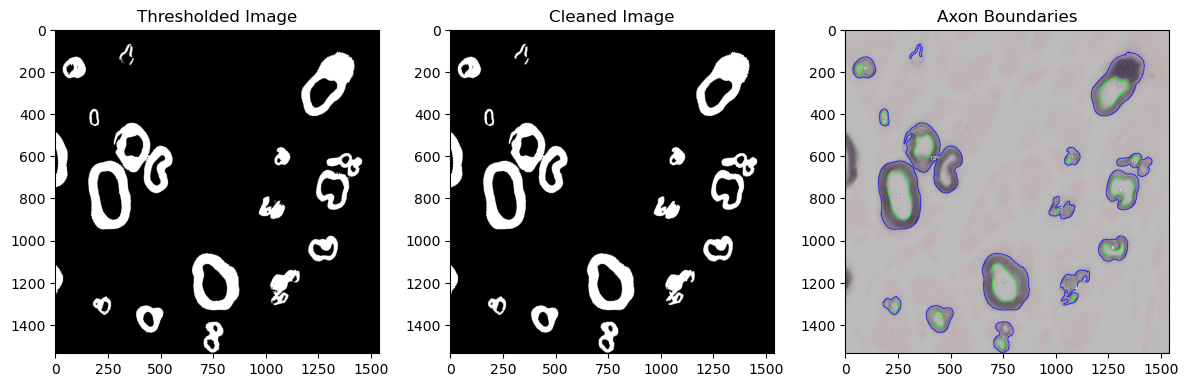


Axon 1:
  Outer Center = (977.44, 1313.61)µm
  Inner Center = (989.00, 1283.00)µm
  Outer Radius = 8.9049 µm
  Inner Radius = 1.0358 µm
  Thickness = 7.8692 µm
  Diameter = 17.8098 µm
  Outer Area = 180.6319 µm²
  Inner Area = 2.2010 µm²
  Area Ratio = 0.0122

Axon 2:
  Outer Center = (1002.17, 1140.57)µm
  Inner Center = (985.00, 1137.50)µm
  Outer Radius = 6.9575 µm
  Inner Radius = 2.8013 µm
  Thickness = 4.1563 µm
  Diameter = 13.9150 µm
  Outer Area = 110.1992 µm²
  Inner Area = 10.8756 µm²
  Area Ratio = 0.0987

Axon 3:
  Outer Center = (328.50, 1030.54)µm
  Inner Center = (321.04, 1044.00)µm
  Outer Radius = 8.1954 µm
  Inner Radius = 3.6241 µm
  Thickness = 4.5713 µm
  Diameter = 16.3908 µm
  Outer Area = 152.6290 µm²
  Inner Area = 24.6644 µm²
  Area Ratio = 0.1616

Axon 4:
  Outer Center = (850.22, 938.08)µm
  Inner Center = (849.40, 959.58)µm
  Outer Radius = 10.4008 µm
  Inner Radius = 4.3361 µm
  Thickness = 6.0647 µm
  Diameter = 20.8016 µm
  Outer Area = 202.8364 µm²
  

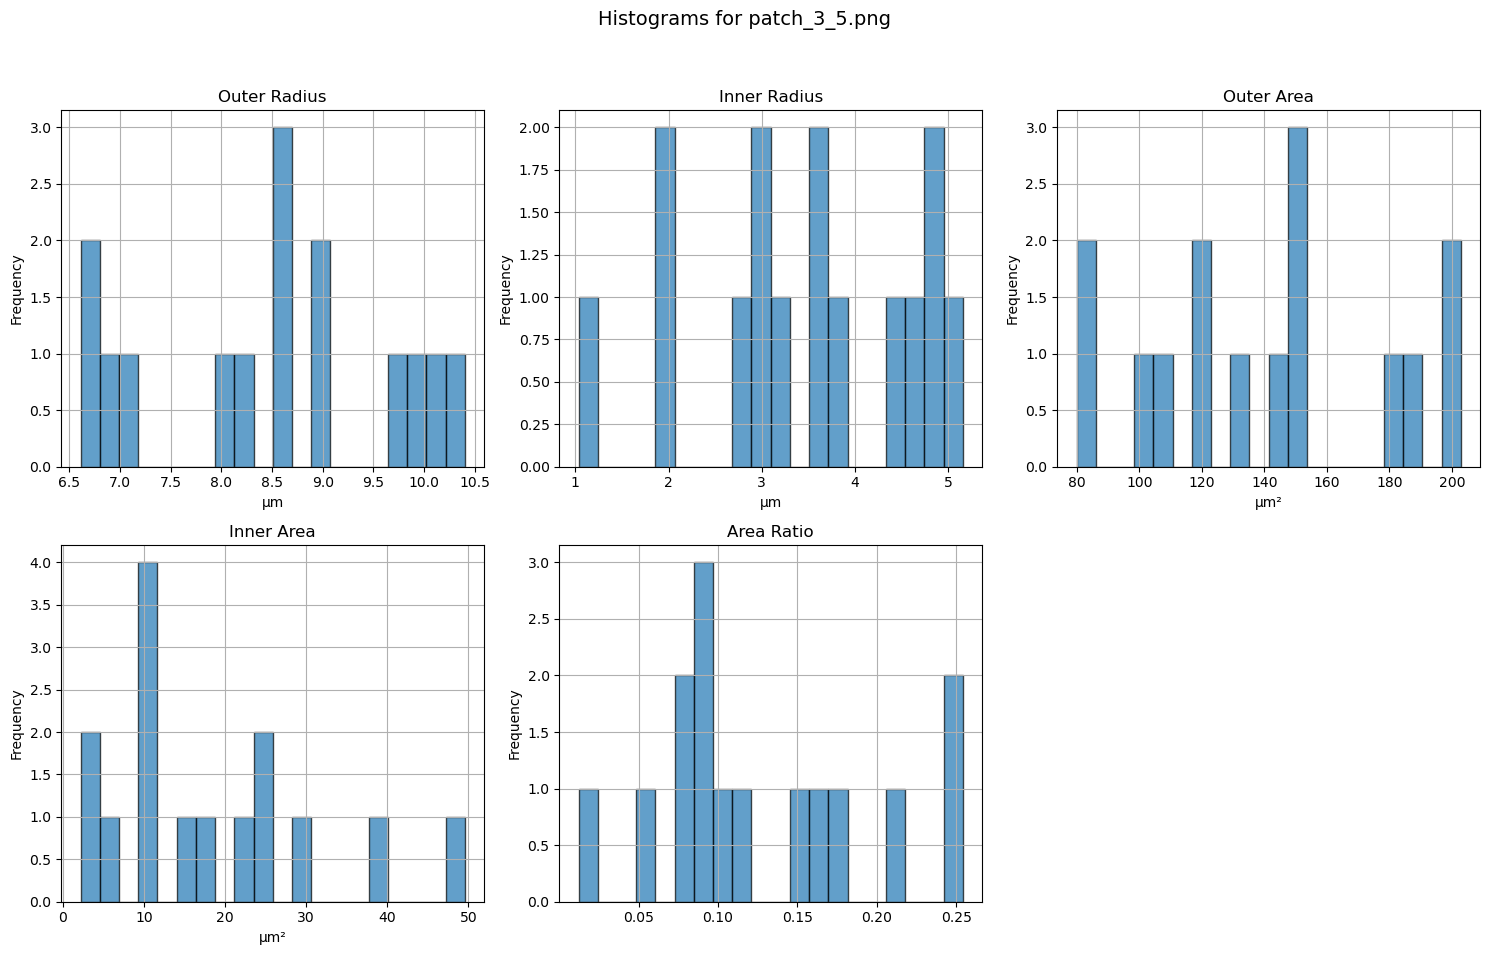

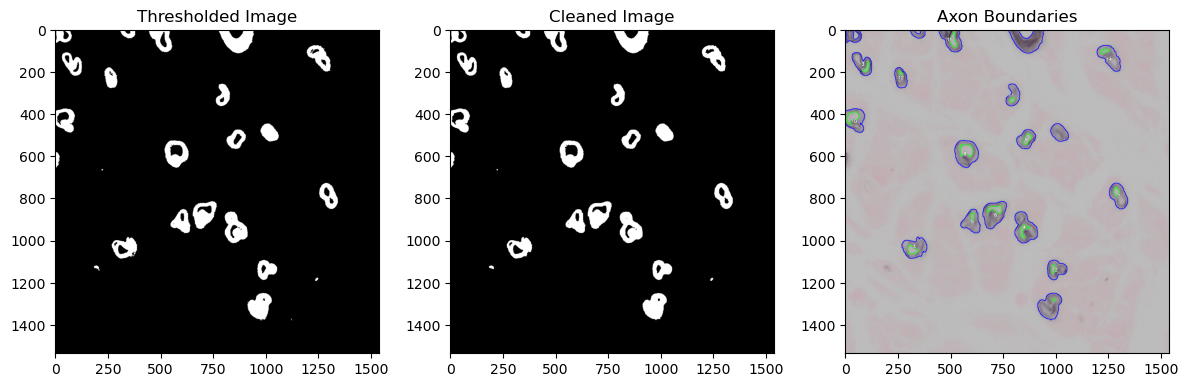


Axon 1:
  Outer Center = (1368.50, 1339.50)µm
  Inner Center = (1355.51, 1350.79)µm
  Outer Radius = 11.2581 µm
  Inner Radius = 5.5632 µm
  Thickness = 5.6948 µm
  Diameter = 22.5161 µm
  Outer Area = 284.9309 µm²
  Inner Area = 73.2996 µm²
  Area Ratio = 0.2573

Axon 2:
  Outer Center = (1036.07, 1311.68)µm
  Inner Center = (1034.19, 1312.68)µm
  Outer Radius = 11.5320 µm
  Inner Radius = 8.1635 µm
  Thickness = 3.3685 µm
  Diameter = 23.0640 µm
  Outer Area = 265.4916 µm²
  Inner Area = 77.0543 µm²
  Area Ratio = 0.2902

Axon 3:
  Outer Center = (1153.00, 1218.00)µm
  Inner Center = (1155.25, 1217.38)µm
  Outer Radius = 7.1371 µm
  Inner Radius = 4.6983 µm
  Thickness = 2.4388 µm
  Diameter = 14.2742 µm
  Outer Area = 110.5598 µm²
  Inner Area = 37.5839 µm²
  Area Ratio = 0.3399

Axon 4:
  Outer Center = (708.50, 1264.50)µm
  Inner Center = (712.00, 1263.50)µm
  Outer Radius = 11.5948 µm
  Inner Radius = 8.5488 µm
  Thickness = 3.0459 µm
  Diameter = 23.1895 µm
  Outer Area = 290.8

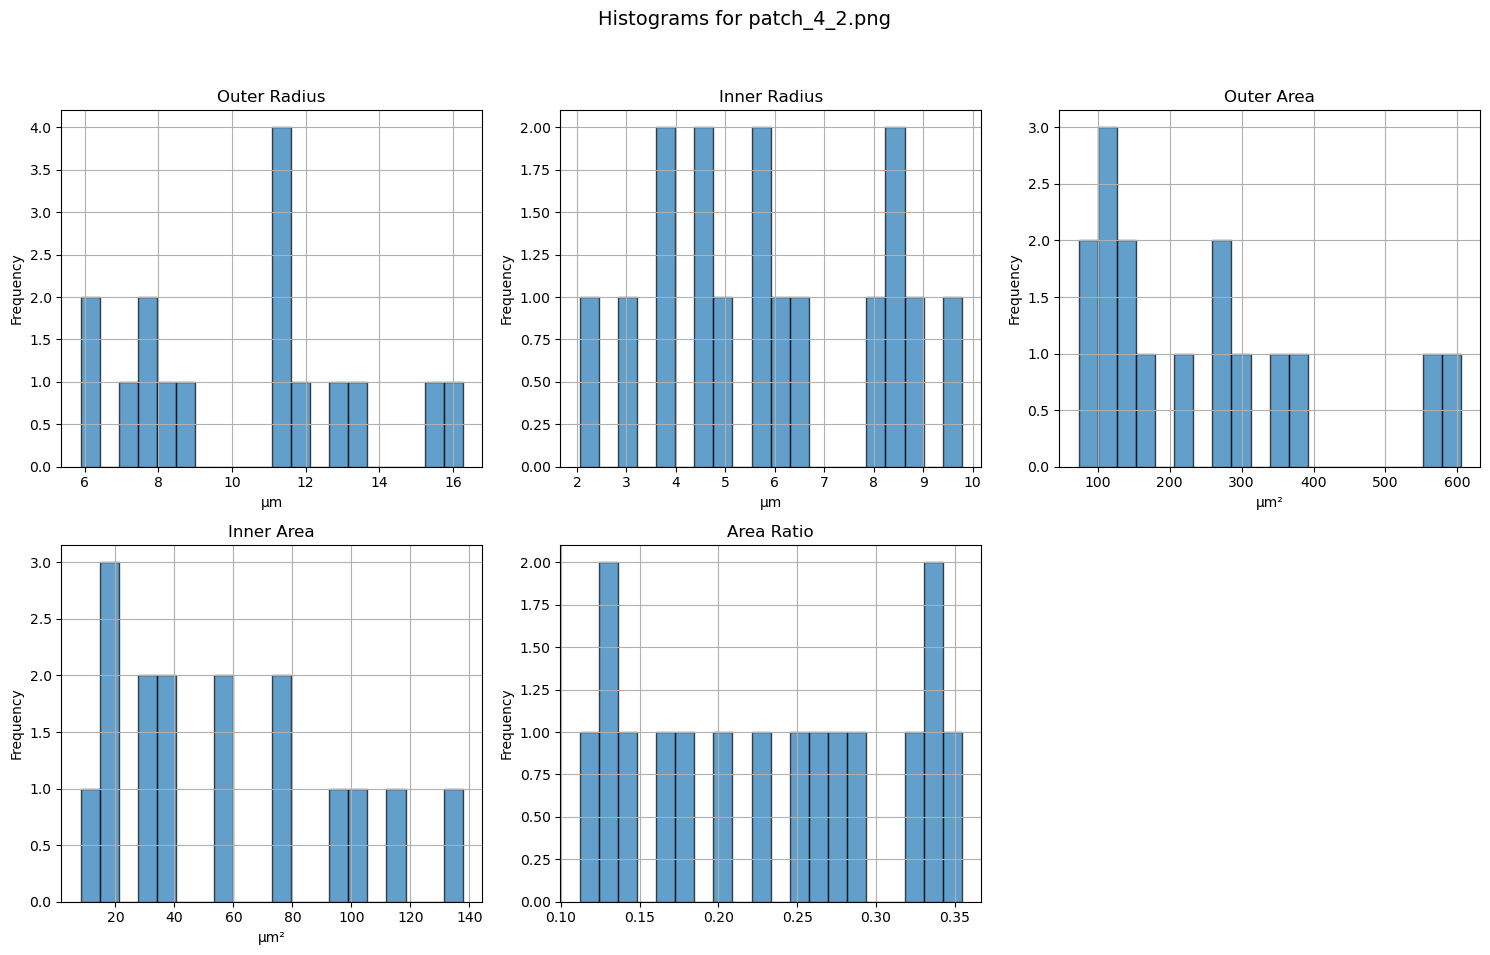

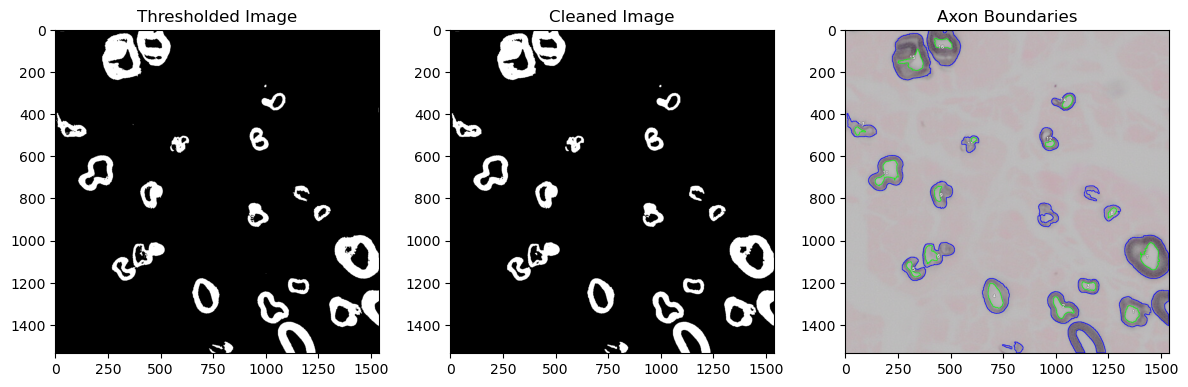


Axon 1:
  Outer Center = (1105.67, 1364.10)µm
  Inner Center = (1101.50, 1386.50)µm
  Outer Radius = 7.3992 µm
  Inner Radius = 2.9874 µm
  Thickness = 4.4118 µm
  Diameter = 14.7983 µm
  Outer Area = 86.7000 µm²
  Inner Area = 9.5994 µm²
  Area Ratio = 0.1107

Axon 2:
  Outer Center = (186.50, 1325.00)µm
  Inner Center = (189.50, 1320.50)µm
  Outer Radius = 6.3619 µm
  Inner Radius = 3.3878 µm
  Thickness = 2.9742 µm
  Diameter = 12.7238 µm
  Outer Area = 93.6637 µm²
  Inner Area = 20.2901 µm²
  Area Ratio = 0.2166

Axon 3:
  Outer Center = (619.00, 1346.00)µm
  Inner Center = (644.50, 1355.50)µm
  Outer Radius = 16.5926 µm
  Inner Radius = 9.9480 µm
  Thickness = 6.6446 µm
  Diameter = 33.1851 µm
  Outer Area = 465.0819 µm²
  Inner Area = 176.4333 µm²
  Area Ratio = 0.3794

Axon 4:
  Outer Center = (8.00, 1232.00)µm
  Inner Center = (25.00, 1251.00)µm
  Outer Radius = 7.6933 µm
  Inner Radius = 0.1360 µm
  Thickness = 7.5573 µm
  Diameter = 15.3867 µm
  Outer Area = 50.1519 µm²
  In

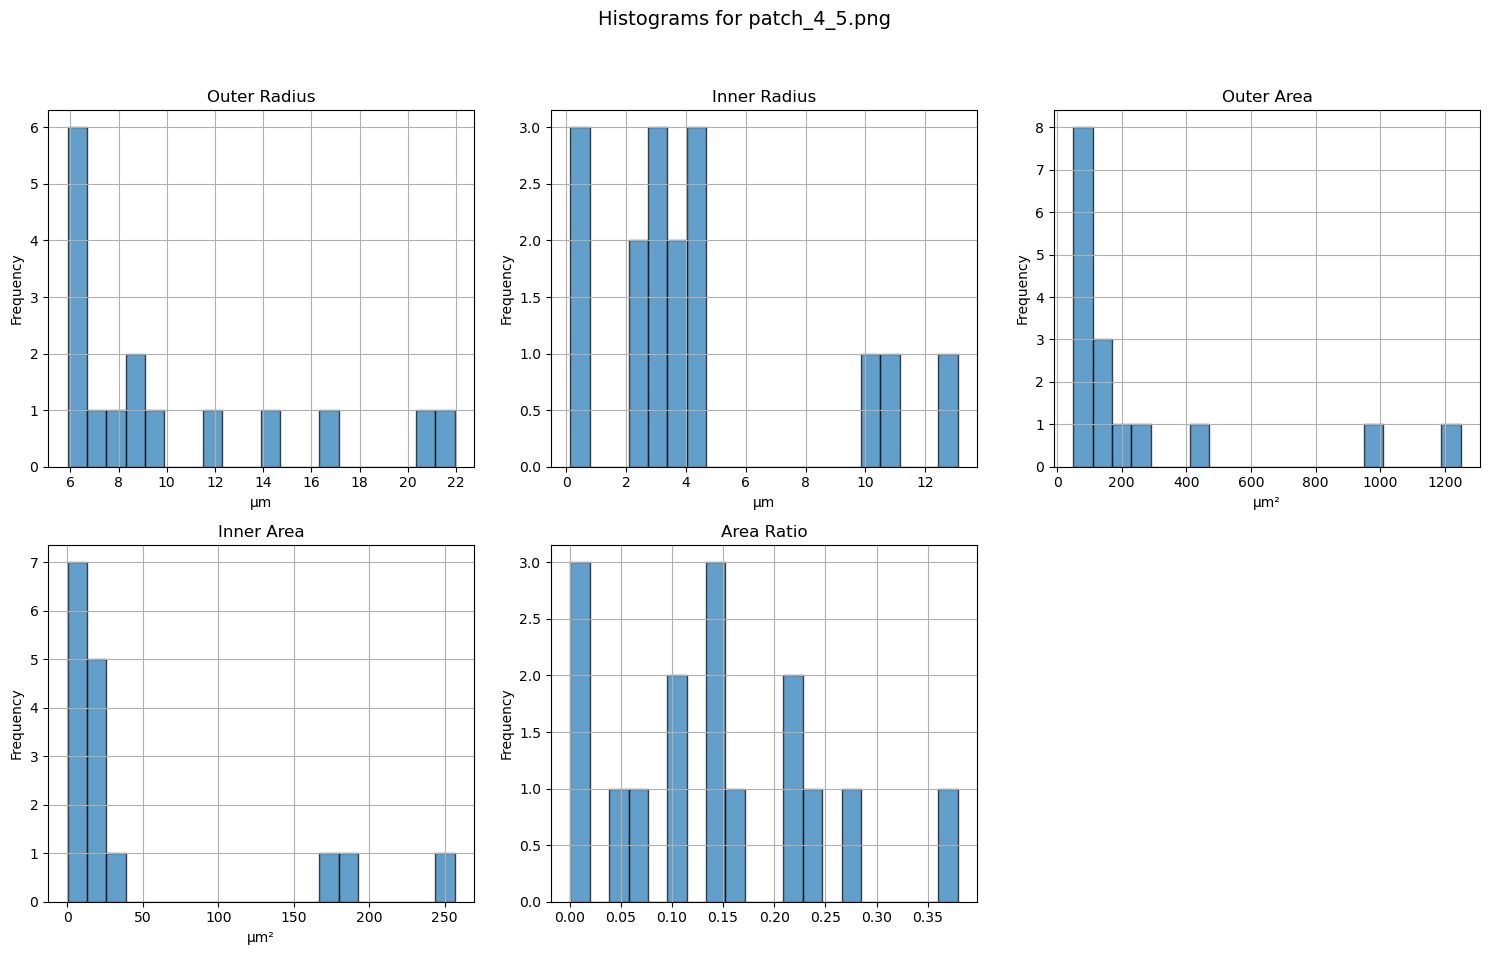

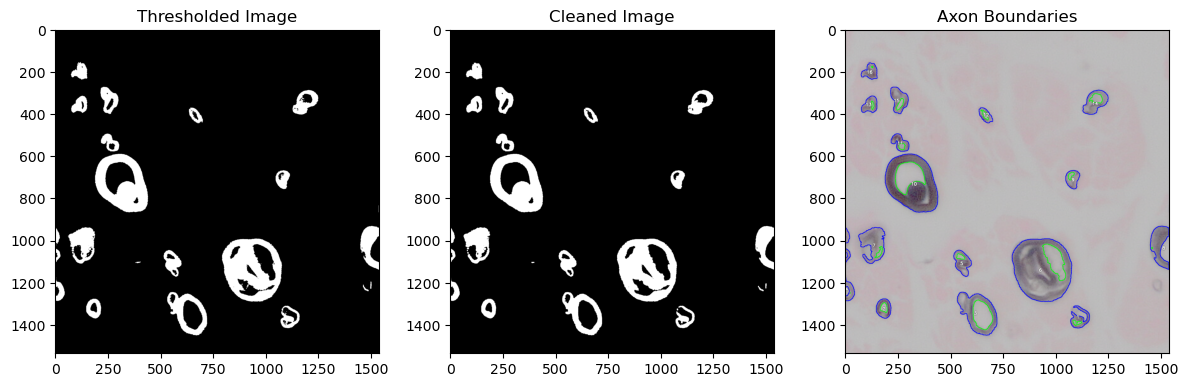


Axon 1:
  Outer Center = (195.50, 1182.50)µm
  Inner Center = (204.84, 1192.54)µm
  Outer Radius = 15.4434 µm
  Inner Radius = 10.7997 µm
  Thickness = 4.6436 µm
  Diameter = 30.8867 µm
  Outer Area = 496.9875 µm²
  Inner Area = 213.2589 µm²
  Area Ratio = 0.4291

Axon 2:
  Outer Center = (13.00, 1043.50)µm
  Inner Center = (49.00, 1100.00)µm
  Outer Radius = 13.6470 µm
  Inner Radius = 1.1215 µm
  Thickness = 12.5255 µm
  Diameter = 27.2940 µm
  Outer Area = 136.7872 µm²
  Inner Area = 1.2855 µm²
  Area Ratio = 0.0094

Axon 3:
  Outer Center = (1341.28, 943.38)µm
  Inner Center = (1324.75, 945.92)µm
  Outer Radius = 9.2336 µm
  Inner Radius = 5.2902 µm
  Thickness = 3.9435 µm
  Diameter = 18.4673 µm
  Outer Area = 177.1269 µm²
  Inner Area = 27.1891 µm²
  Area Ratio = 0.1535

Axon 4:
  Outer Center = (111.50, 881.00)µm
  Inner Center = (108.00, 879.50)µm
  Outer Radius = 18.1295 µm
  Inner Radius = 13.3282 µm
  Thickness = 4.8013 µm
  Diameter = 36.2590 µm
  Outer Area = 637.8623 µm²

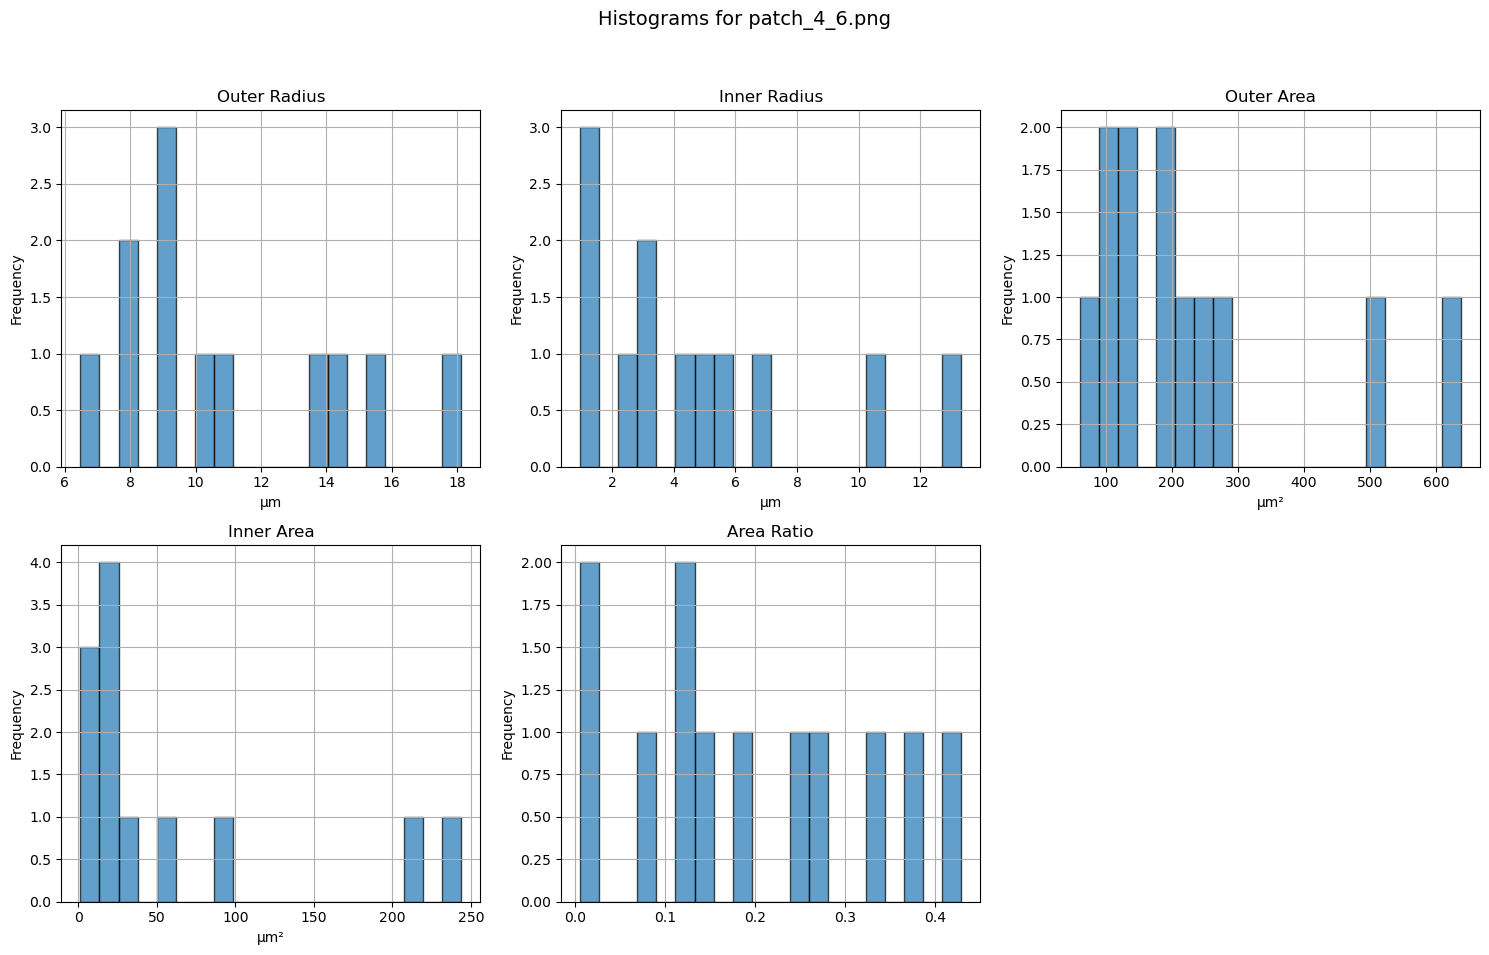

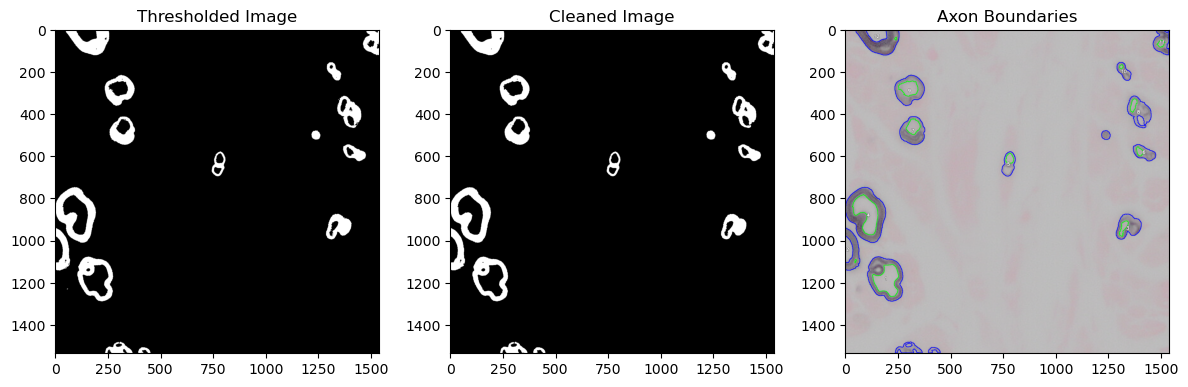


Axon 1:
  Outer Center = (415.12, 1431.42)µm
  Inner Center = (415.50, 1433.50)µm
  Outer Radius = 5.9098 µm
  Inner Radius = 3.6047 µm
  Thickness = 2.3051 µm
  Diameter = 11.8196 µm
  Outer Area = 61.9616 µm²
  Inner Area = 17.2568 µm²
  Area Ratio = 0.2785

Axon 2:
  Outer Center = (277.50, 1449.50)µm
  Inner Center = (268.50, 1403.50)µm
  Outer Radius = 11.6171 µm
  Inner Radius = 4.1307 µm
  Thickness = 7.4864 µm
  Diameter = 23.2341 µm
  Outer Area = 233.4473 µm²
  Inner Area = 29.7601 µm²
  Area Ratio = 0.1275

Axon 3:
  Outer Center = (766.90, 1202.10)µm
  Inner Center = (752.50, 1193.50)µm
  Outer Radius = 7.2390 µm
  Inner Radius = 3.5005 µm
  Thickness = 3.7385 µm
  Diameter = 14.4780 µm
  Outer Area = 124.6076 µm²
  Inner Area = 12.1519 µm²
  Area Ratio = 0.0975

Axon 4:
  Outer Center = (1406.50, 1050.77)µm
  Inner Center = (1379.21, 1049.21)µm
  Outer Radius = 8.4108 µm
  Inner Radius = 2.1148 µm
  Thickness = 6.2960 µm
  Diameter = 16.8216 µm
  Outer Area = 155.9398 µm²

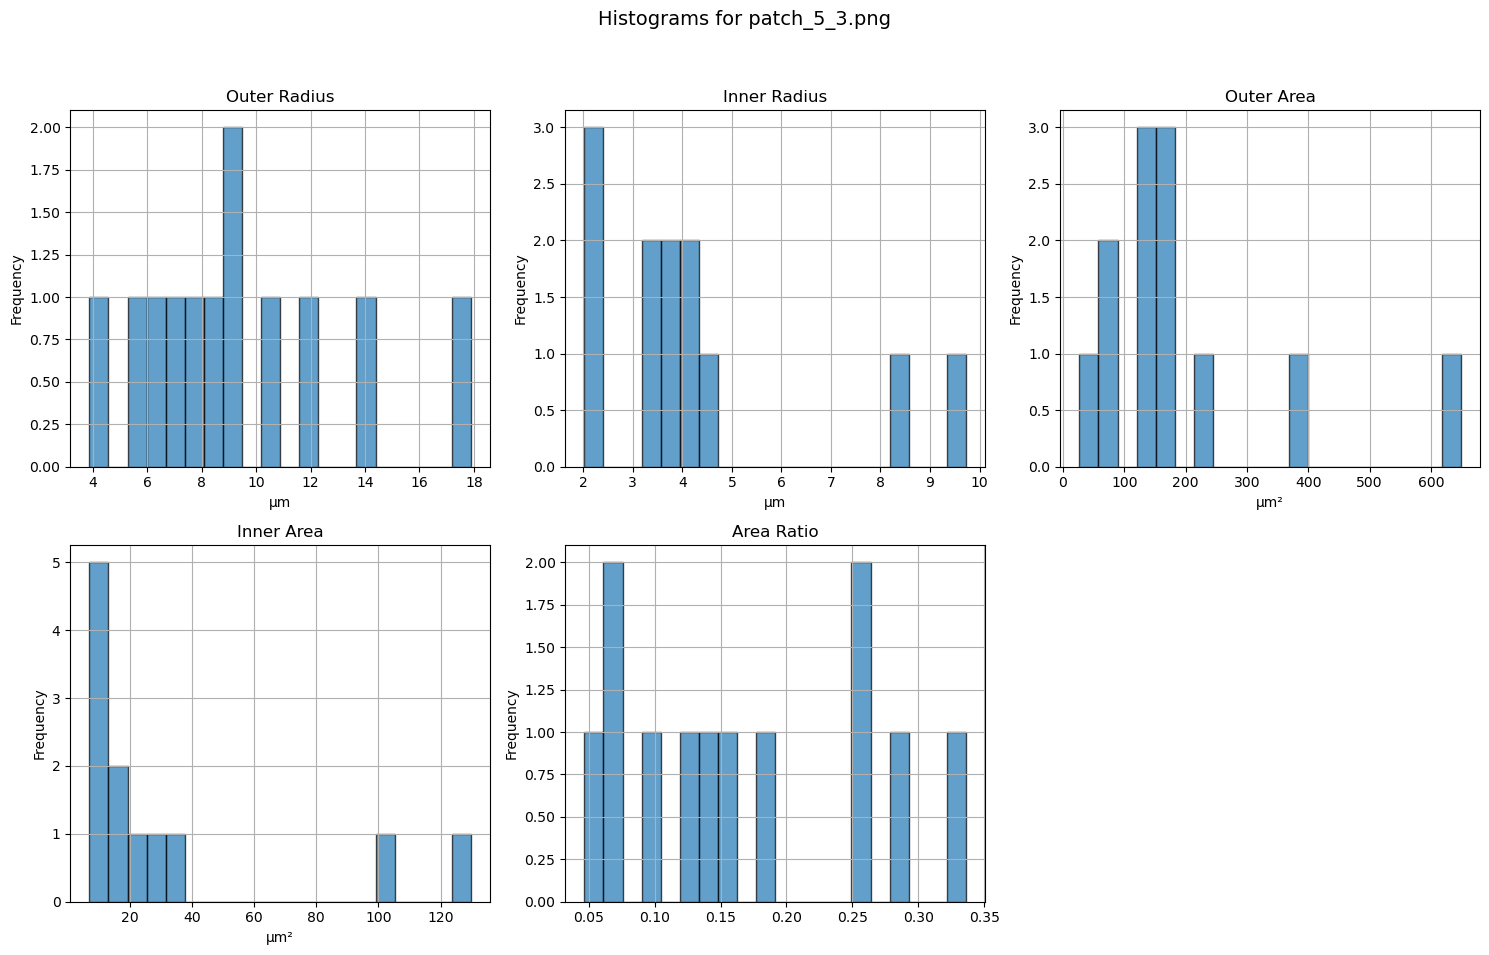

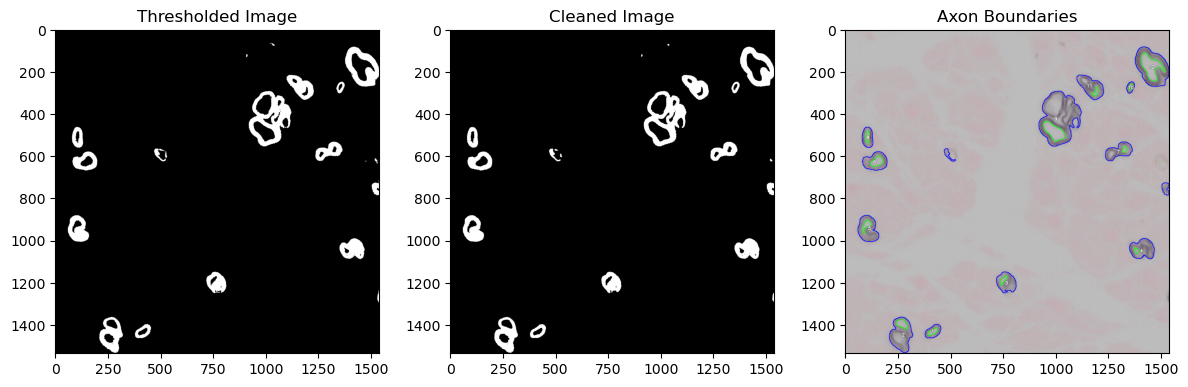


Axon 1:
  Outer Center = (866.50, 1436.50)µm
  Inner Center = (939.22, 1406.68)µm
  Outer Radius = 22.6727 µm
  Inner Radius = 8.6636 µm
  Thickness = 14.0091 µm
  Diameter = 45.3454 µm
  Outer Area = 589.3380 µm²
  Inner Area = 150.0396 µm²
  Area Ratio = 0.2546

Axon 2:
  Outer Center = (1271.10, 1369.30)µm
  Inner Center = (1261.15, 1394.00)µm
  Outer Radius = 8.4235 µm
  Inner Radius = 1.6113 µm
  Thickness = 6.8122 µm
  Diameter = 16.8471 µm
  Outer Area = 145.4988 µm²
  Inner Area = 5.1789 µm²
  Area Ratio = 0.0356

Axon 3:
  Outer Center = (464.59, 1275.20)µm
  Inner Center = (439.50, 1266.00)µm
  Outer Radius = 8.0443 µm
  Inner Radius = 3.4972 µm
  Thickness = 4.5470 µm
  Diameter = 16.0885 µm
  Outer Area = 118.0415 µm²
  Inner Area = 24.5997 µm²
  Area Ratio = 0.2084

Axon 4:
  Outer Center = (292.50, 1191.50)µm
  Inner Center = (294.39, 1214.77)µm
  Outer Radius = 9.6383 µm
  Inner Radius = 4.0325 µm
  Thickness = 5.6058 µm
  Diameter = 19.2766 µm
  Outer Area = 164.4942 µ

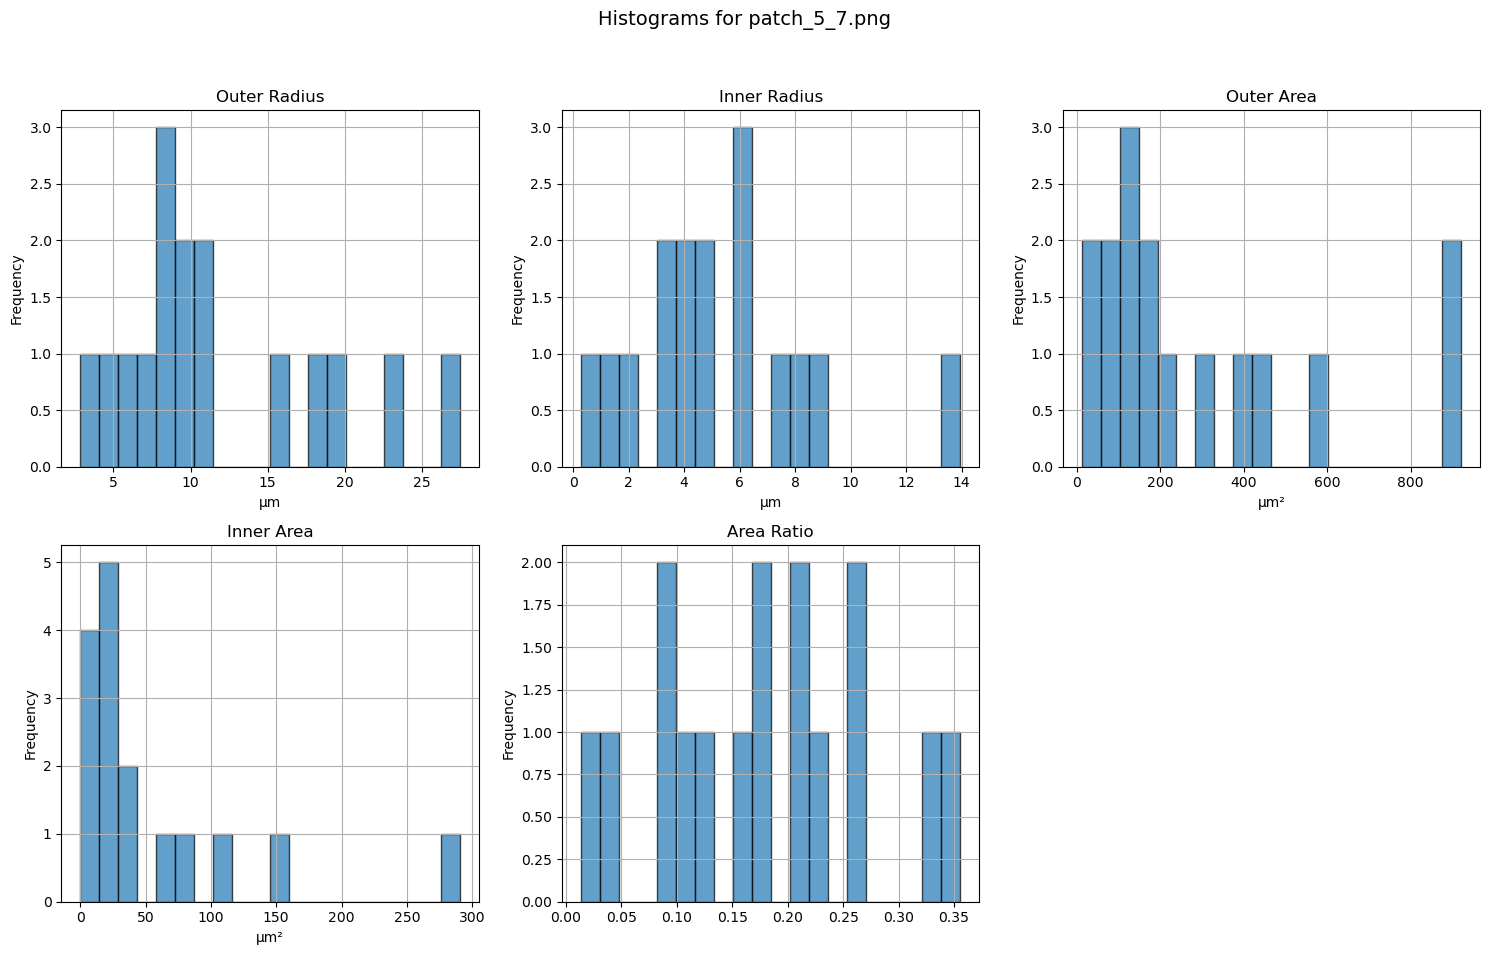

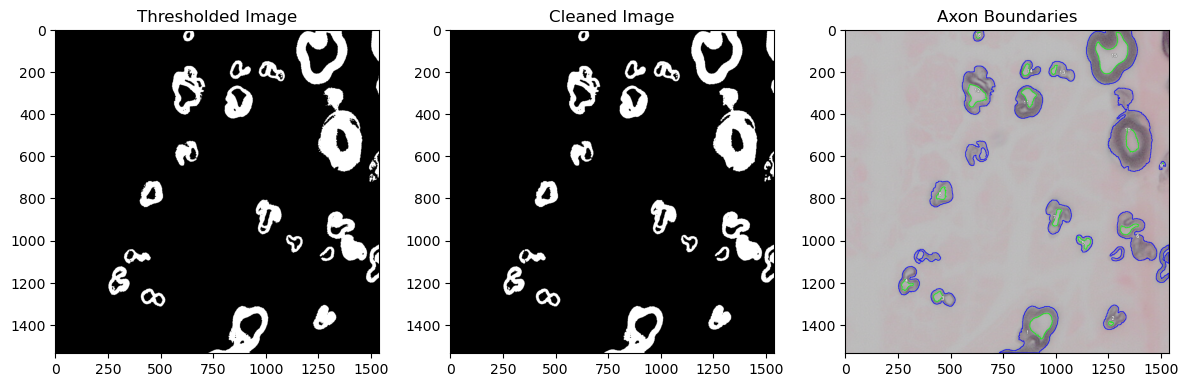


Axon 1:
  Outer Center = (182.00, 1405.00)µm
  Inner Center = (177.50, 1408.50)µm
  Outer Radius = 17.6486 µm
  Inner Radius = 12.1311 µm
  Thickness = 5.5175 µm
  Diameter = 35.2972 µm
  Outer Area = 681.5129 µm²
  Inner Area = 221.9058 µm²
  Area Ratio = 0.3256

Axon 2:
  Outer Center = (23.33, 1183.55)µm
  Inner Center = (21.00, 1185.00)µm
  Outer Radius = 4.0285 µm
  Inner Radius = 2.6160 µm
  Thickness = 1.4125 µm
  Diameter = 8.0571 µm
  Outer Area = 39.1930 µm²
  Inner Area = 13.2801 µm²
  Area Ratio = 0.3388

Axon 3:
  Outer Center = (405.25, 1247.25)µm
  Inner Center = (410.50, 1252.00)µm
  Outer Radius = 17.2626 µm
  Inner Radius = 11.8790 µm
  Thickness = 5.3836 µm
  Diameter = 34.5252 µm
  Outer Area = 444.4959 µm²
  Inner Area = 114.2960 µm²
  Area Ratio = 0.2571

Axon 4:
  Outer Center = (608.00, 1070.00)µm
  Inner Center = (609.12, 1070.57)µm
  Outer Radius = 4.3541 µm
  Inner Radius = 3.0449 µm
  Thickness = 1.3092 µm
  Diameter = 8.7083 µm
  Outer Area = 44.4736 µm²
 

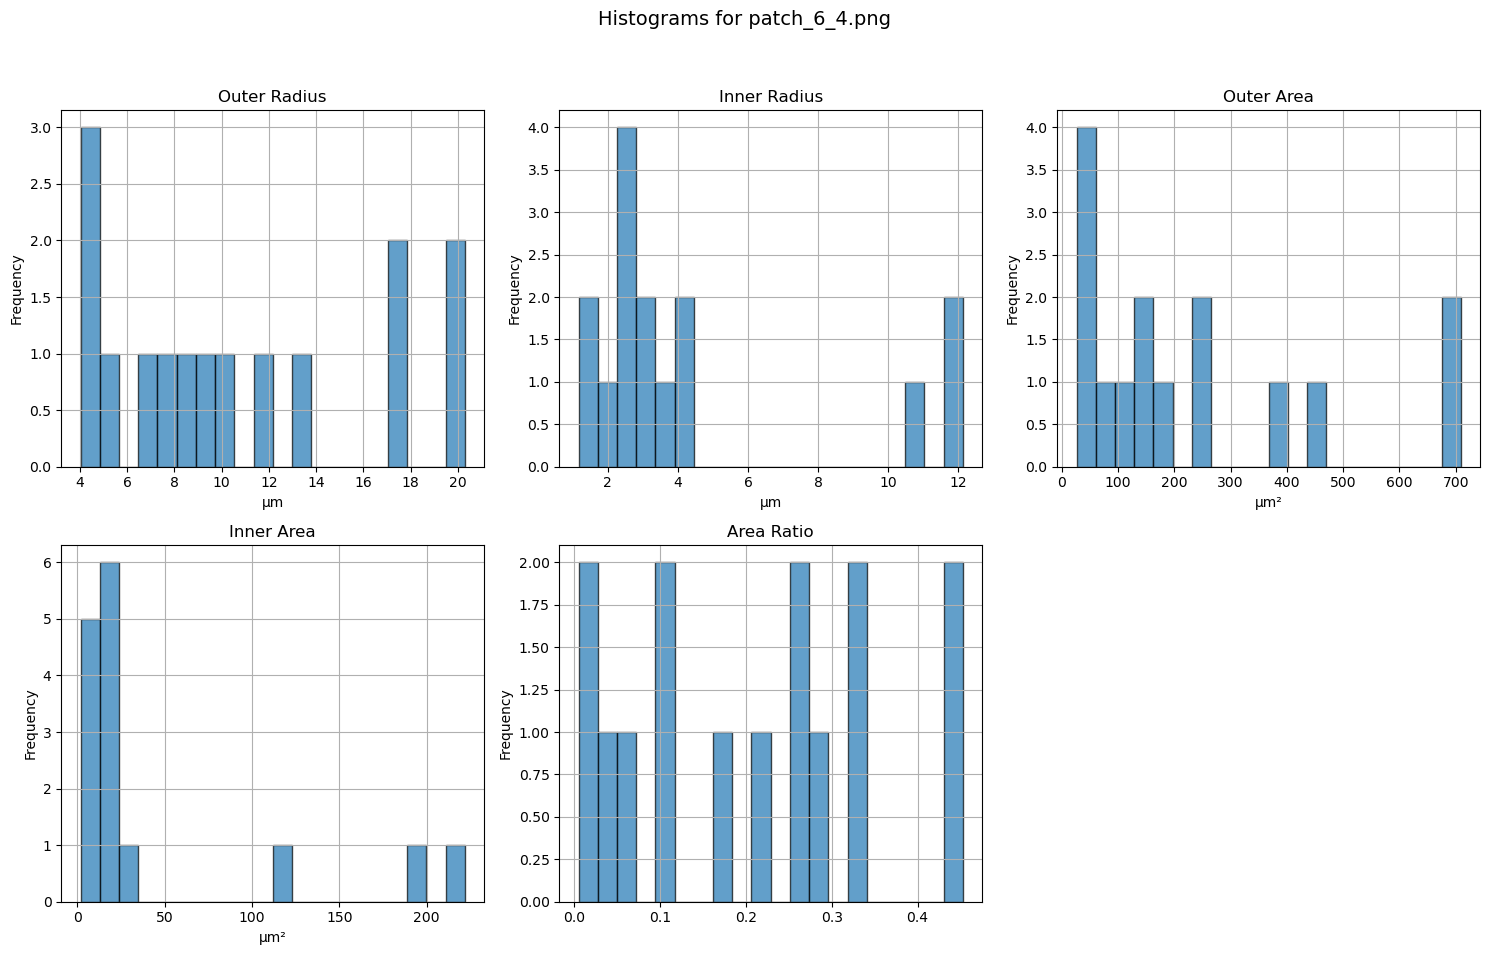

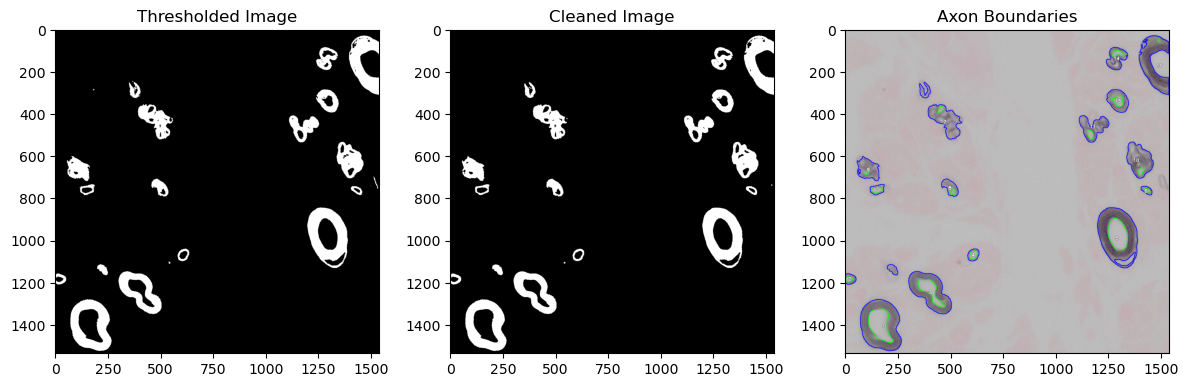


Axon 1:
  Outer Center = (414.28, 1409.39)µm
  Inner Center = (413.09, 1405.72)µm
  Outer Radius = 19.4725 µm
  Inner Radius = 7.8340 µm
  Thickness = 11.6385 µm
  Diameter = 38.9451 µm
  Outer Area = 976.2651 µm²
  Inner Area = 105.1313 µm²
  Area Ratio = 0.1077

Axon 2:
  Outer Center = (995.94, 1268.82)µm
  Inner Center = (1001.83, 1295.16)µm
  Outer Radius = 8.5858 µm
  Inner Radius = 2.7258 µm
  Thickness = 5.8600 µm
  Diameter = 17.1717 µm
  Outer Area = 161.8770 µm²
  Inner Area = 13.6131 µm²
  Area Ratio = 0.0841

Axon 3:
  Outer Center = (415.54, 1185.07)µm
  Inner Center = (401.81, 1187.65)µm
  Outer Radius = 11.2915 µm
  Inner Radius = 7.6849 µm
  Thickness = 3.6066 µm
  Diameter = 22.5830 µm
  Outer Area = 296.9718 µm²
  Inner Area = 95.4209 µm²
  Area Ratio = 0.3213

Axon 4:
  Outer Center = (826.50, 1013.50)µm
  Inner Center = (825.00, 988.00)µm
  Outer Radius = 5.1222 µm
  Inner Radius = 0.5608 µm
  Thickness = 4.5614 µm
  Diameter = 10.2444 µm
  Outer Area = 37.3989 µm

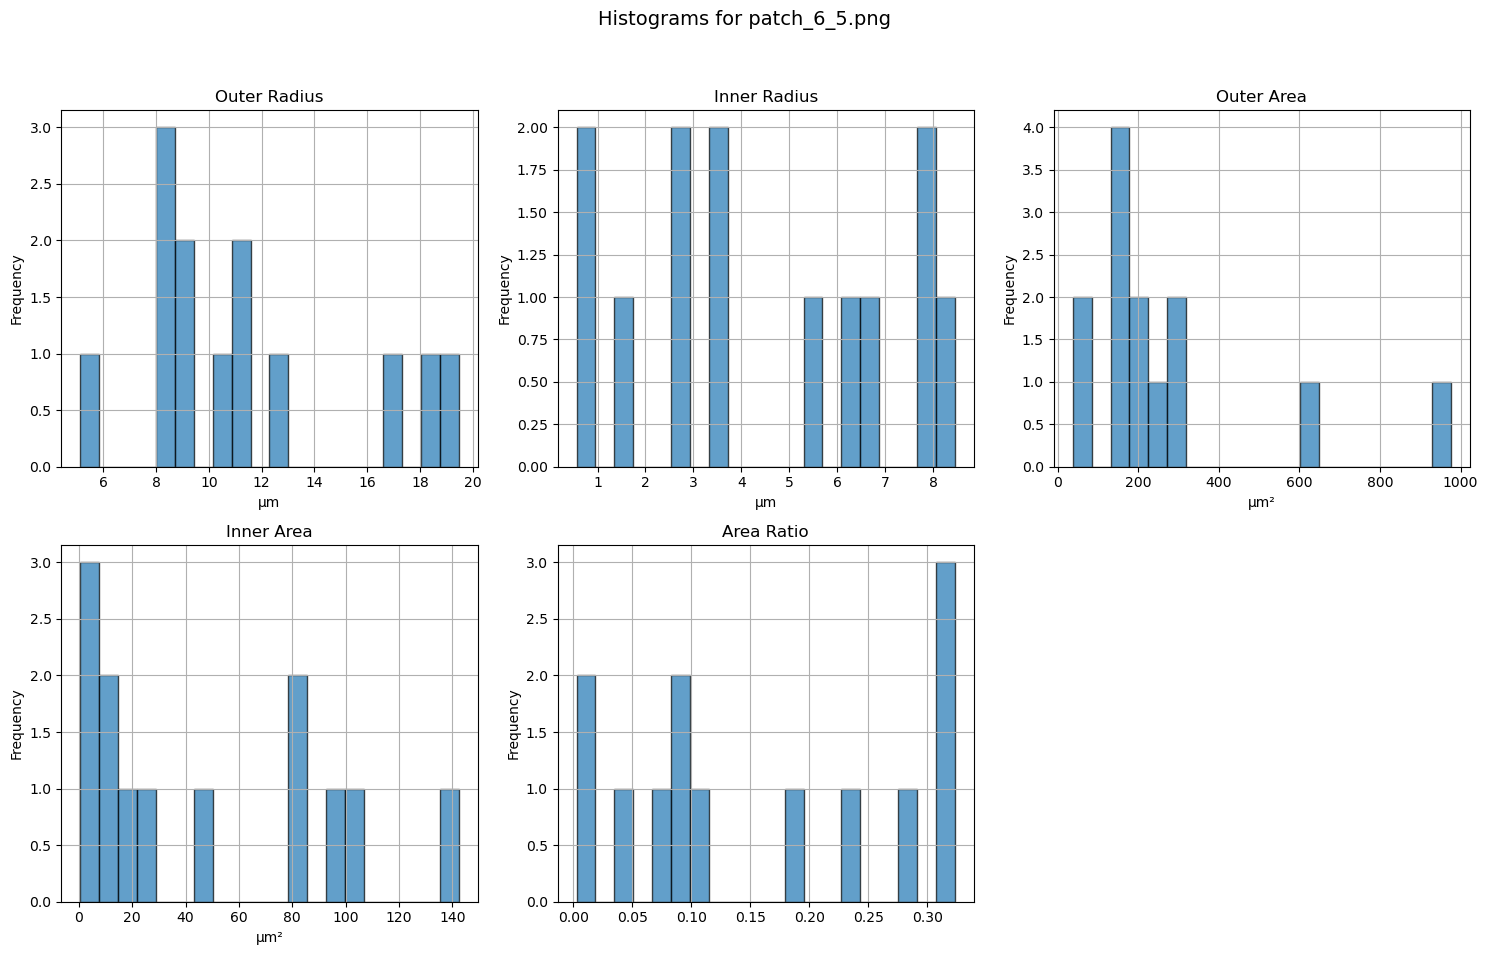

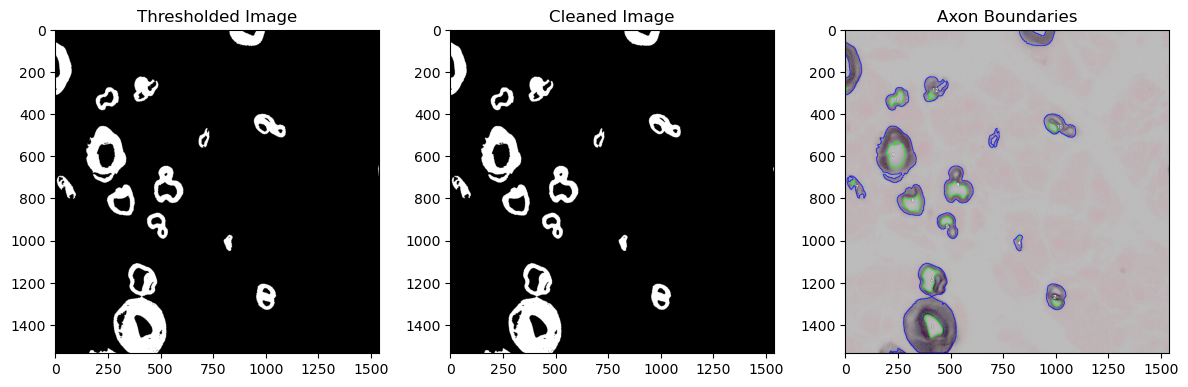


Axon 1:
  Outer Center = (262.50, 1234.00)µm
  Inner Center = (258.15, 1255.54)µm
  Outer Radius = 18.9510 µm
  Inner Radius = 5.9094 µm
  Thickness = 13.0416 µm
  Diameter = 37.9021 µm
  Outer Area = 480.5261 µm²
  Inner Area = 72.3933 µm²
  Area Ratio = 0.1507

Axon 2:
  Outer Center = (759.23, 1102.50)µm
  Inner Center = (780.89, 1140.80)µm
  Outer Radius = 9.3014 µm
  Inner Radius = 3.7122 µm
  Thickness = 5.5892 µm
  Diameter = 18.6028 µm
  Outer Area = 187.8269 µm²
  Inner Area = 25.7649 µm²
  Area Ratio = 0.1372

Axon 3:
  Outer Center = (461.95, 1039.05)µm
  Inner Center = (467.05, 1053.68)µm
  Outer Radius = 7.8201 µm
  Inner Radius = 4.5302 µm
  Thickness = 3.2900 µm
  Diameter = 15.6403 µm
  Outer Area = 129.3980 µm²
  Inner Area = 23.2217 µm²
  Area Ratio = 0.1795

Axon 4:
  Outer Center = (1100.65, 876.90)µm
  Inner Center = (1099.00, 879.00)µm
  Outer Radius = 9.1728 µm
  Inner Radius = 6.8000 µm
  Thickness = 2.3728 µm
  Diameter = 18.3457 µm
  Outer Area = 132.7180 µm²

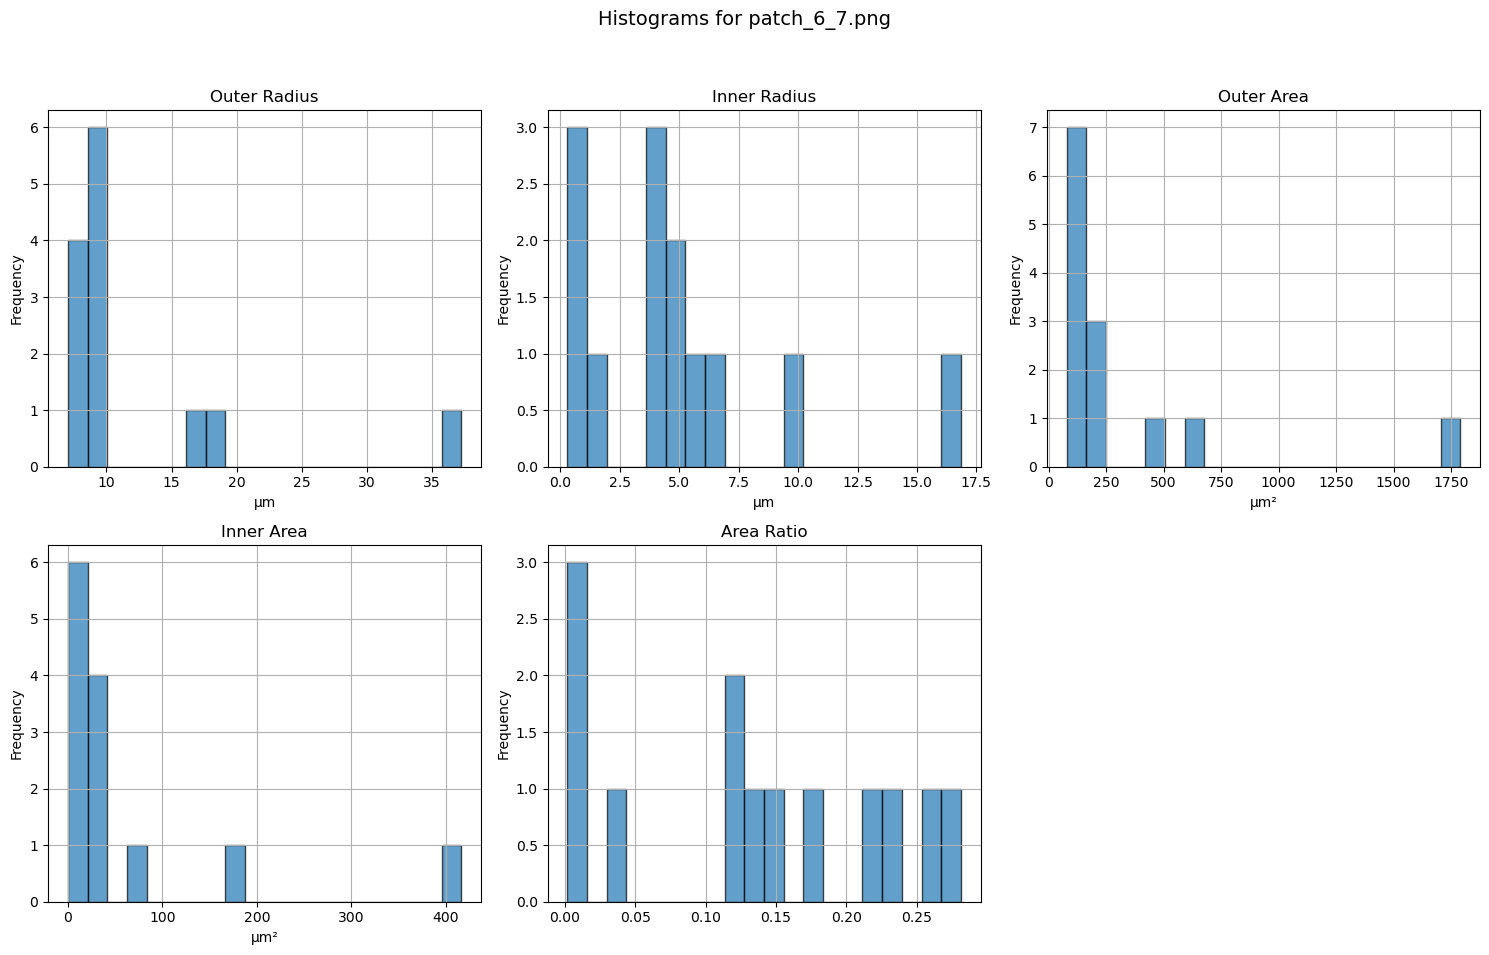

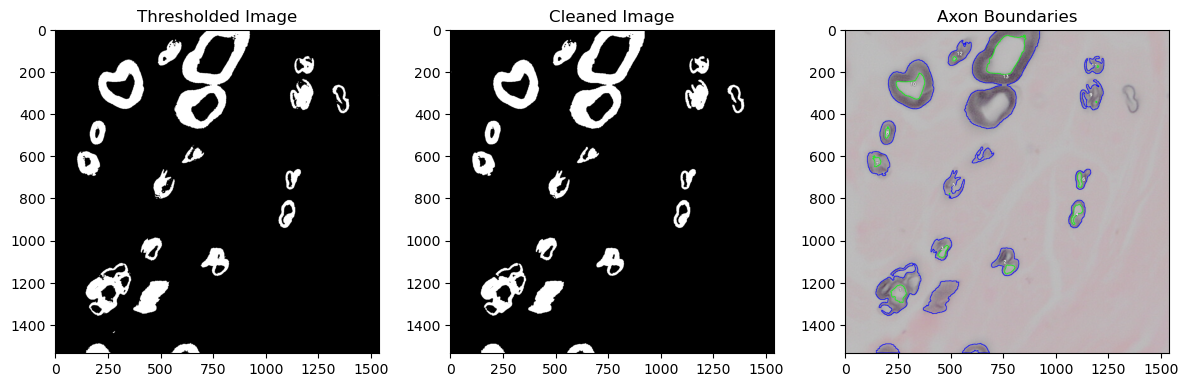

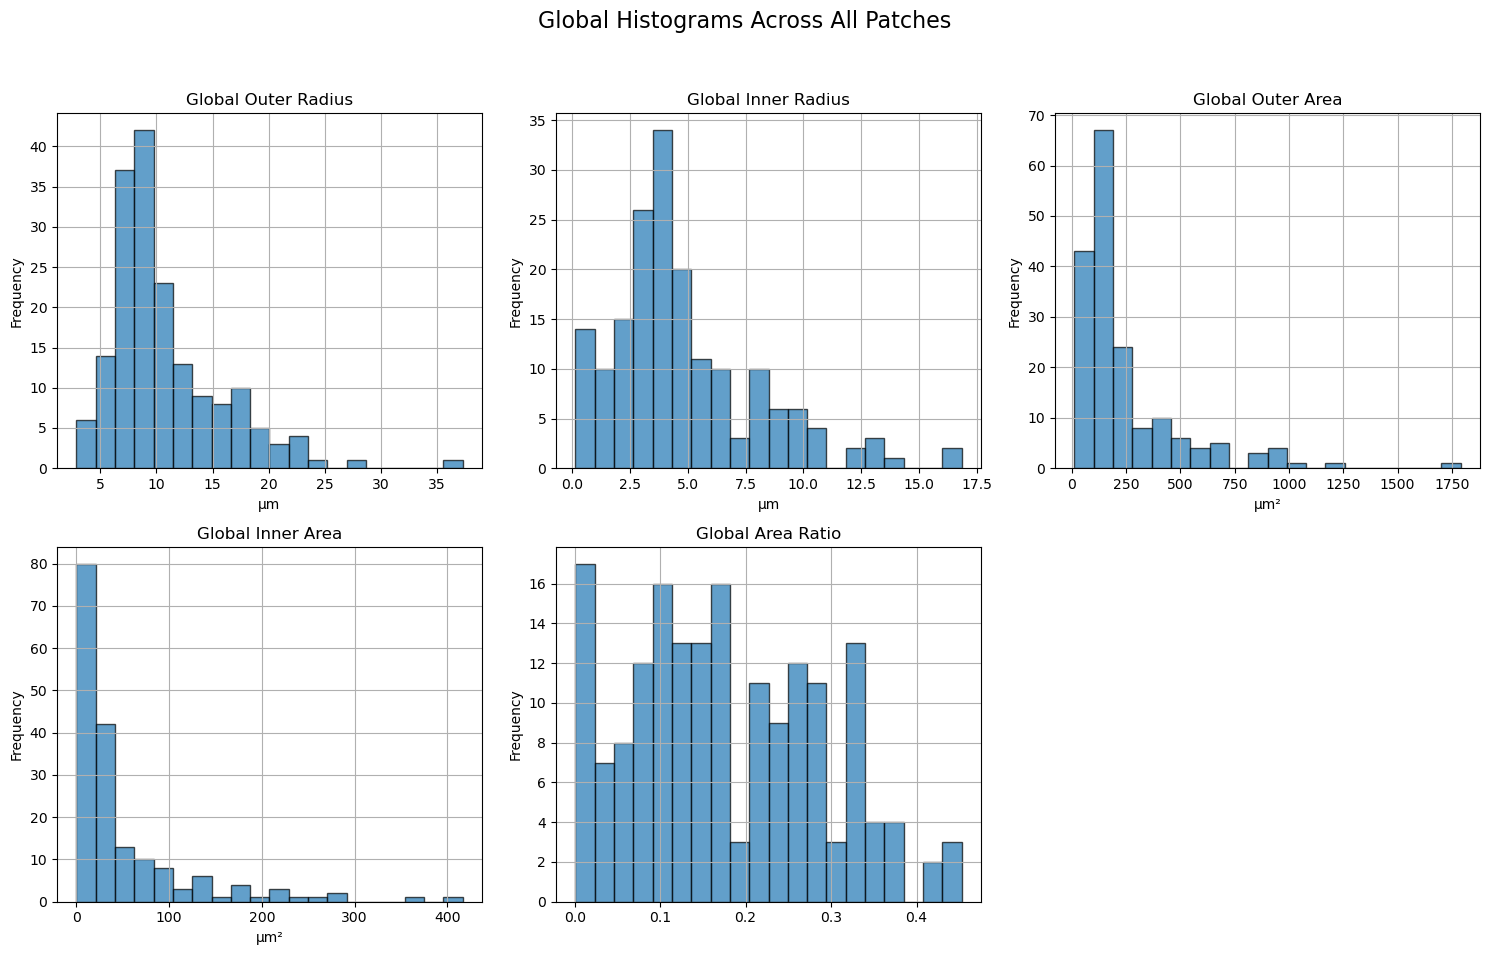


📊 Global Summary Statistics:
Outer Radius (µm):
  Mean   = 10.8140
  Median = 9.2806
  Std    = 5.0335
Inner Radius (µm):
  Mean   = 4.7832
  Median = 3.9229
  Std    = 3.1854
Outer Area (µm²):
  Mean   = 247.9161
  Median = 156.7998
  Std    = 251.6025
Inner Area (µm²):
  Mean   = 49.6485
  Median = 23.1940
  Std    = 68.8412
Area Ratio:
  Mean   = 0.1762
  Median = 0.1646
  Std    = 0.1119

✅ All images processed and saved to 'C:\Users\sanje\Downloads\general_patches_graphs'


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import statistics

# Input and output paths
input_folder = r'C:\Users\sanje\Downloads\patches_processed'
output_folder = r"C:\Users\sanje\Downloads\general_patches_graphs"
os.makedirs(output_folder, exist_ok=True)

scale_factor = 0.136  # pixels to micrometers

# Store global data
global_outer_radius = []
global_inner_radius = []
global_outer_area = []
global_inner_area = []
global_area_ratio = []

def darken_and_sharpen(image):
    darkened = cv2.convertScaleAbs(image, alpha=1.1, beta=-10)
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(darkened, -1, sharpen_kernel)

def filter_dark_regions(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    dark_mask = cv2.inRange(L, 0, 250)
    return cv2.bitwise_and(image, image, mask=dark_mask)

def plot_histogram(data, title, xlabel):
    plt.hist(data, bins=20, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.grid(True)

def print_stats(data, label):
    if not data:
        print(f"{label}: No data.")
        return
    print(f"{label}:")
    print(f"  Mean   = {np.mean(data):.4f}")
    print(f"  Median = {np.median(data):.4f}")
    print(f"  Std    = {np.std(data):.4f}")

def process_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = darken_and_sharpen(image)
    image = filter_dark_regions(image)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    contours, hierarchy = cv2.findContours(cleaned, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    axon_data = []
    object_counter = 1
    min_contour_area = 320
    output_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area < min_contour_area:
            continue

        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h if h != 0 else 0
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area if hull_area != 0 else 0

        if aspect_ratio < 0.3 or aspect_ratio > 3.5 or solidity < 0.5:
            continue

        if hierarchy[0][i][3] == -1:
            (x_outer, y_outer), outer_radius = cv2.minEnclosingCircle(contour)
            cv2.drawContours(output_image, [contour], -1, (255, 0, 0), 2)

            largest_inner_contour = None
            max_inner_area = 0
            inner_radius = 0

            for j, inner_contour in enumerate(contours):
                if hierarchy[0][j][3] == i:
                    area = cv2.contourArea(inner_contour)
                    if area > max_inner_area:
                        max_inner_area = area
                        largest_inner_contour = inner_contour
                        (x_inner, y_inner), inner_radius = cv2.minEnclosingCircle(inner_contour)

            if largest_inner_contour is not None:
                cv2.drawContours(output_image, [largest_inner_contour], -1, (0, 255, 0), 2)

                outer_area_px = cv2.contourArea(contour)
                inner_area_px = cv2.contourArea(largest_inner_contour)
                outer_area_um2 = outer_area_px * (scale_factor ** 2)
                inner_area_um2 = inner_area_px * (scale_factor ** 2)
                area_ratio = inner_area_um2 / outer_area_um2 if outer_area_um2 != 0 else 0

                axon_data.append({
                    "axon_id": object_counter,
                    "outer_radius": outer_radius * scale_factor,
                    "inner_radius": inner_radius * scale_factor,
                    "thickness": (outer_radius - inner_radius) * scale_factor,
                    "diameter": (2 * outer_radius) * scale_factor,
                    "center_outer": (x_outer, y_outer),
                    "center_inner": (x_inner, y_inner),
                    "outer_area": outer_area_um2,
                    "inner_area": inner_area_um2,
                    "area_ratio": area_ratio
                })


                # Global data collection
                global_outer_radius.append(outer_radius * scale_factor)
                global_inner_radius.append(inner_radius * scale_factor)
                global_outer_area.append(outer_area_um2)
                global_inner_area.append(inner_area_um2)
                global_area_ratio.append(area_ratio)

                print(f"\nAxon {object_counter}:")
                print(f"  Outer Center = ({x_outer:.2f}, {y_outer:.2f})µm")
                print(f"  Inner Center = ({x_inner:.2f}, {y_inner:.2f})µm")
                print(f"  Outer Radius = {outer_radius * scale_factor:.4f} µm")
                print(f"  Inner Radius = {inner_radius * scale_factor:.4f} µm")
                print(f"  Thickness = {(outer_radius - inner_radius) * scale_factor:.4f} µm")
                print(f"  Diameter = {(2 * outer_radius) * scale_factor:.4f} µm")
                print(f"  Outer Area = {outer_area_um2:.4f} µm²")
                print(f"  Inner Area = {inner_area_um2:.4f} µm²")
                print(f"  Area Ratio = {area_ratio:.4f}")

                text = str(object_counter)
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.7
                thickness = 2
                (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, thickness)
                text_x = int(x_outer - text_width / 2)
                text_y = int(y_outer + text_height / 2)

                cv2.putText(output_image, text, (text_x, text_y), font, font_scale, (0, 0, 0), thickness + 2, cv2.LINE_AA)
                cv2.putText(output_image, text, (text_x, text_y), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

                object_counter += 1

    filename = os.path.basename(image_path)
    output_path = os.path.join(output_folder, f"processed_{filename}")
    cv2.imwrite(output_path, output_image)

    print(f"\n✅ Processed: {filename}")
    print(f"Axons detected: {len(axon_data)}")

    # Plot per-image histograms
    if axon_data:
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 3, 1)
        plot_histogram([axon["outer_radius"] for axon in axon_data], "Outer Radius", "µm")

        plt.subplot(2, 3, 2)
        plot_histogram([axon["inner_radius"] for axon in axon_data], "Inner Radius", "µm")

        plt.subplot(2, 3, 3)
        plot_histogram([axon["outer_area"] for axon in axon_data], "Outer Area", "µm²")

        plt.subplot(2, 3, 4)
        plot_histogram([axon["inner_area"] for axon in axon_data], "Inner Area", "µm²")

        plt.subplot(2, 3, 5)
        plot_histogram([axon["area_ratio"] for axon in axon_data], "Area Ratio", "")

        plt.suptitle(f"Histograms for {os.path.basename(image_path)}", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    return thresh, cleaned, output_image

# Loop through all PNG images
image_paths = glob(os.path.join(input_folder, "*.png"))

for image_path in image_paths:
    thresh, cleaned, output_image = process_image(image_path)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Thresholded Image")
    plt.imshow(thresh, cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("Cleaned Image")
    plt.imshow(cleaned, cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Axon Boundaries")
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    plt.show()

# Final global histograms
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plot_histogram(global_outer_radius, "Global Outer Radius", "µm")

plt.subplot(2, 3, 2)
plot_histogram(global_inner_radius, "Global Inner Radius", "µm")

plt.subplot(2, 3, 3)
plot_histogram(global_outer_area, "Global Outer Area", "µm²")

plt.subplot(2, 3, 4)
plot_histogram(global_inner_area, "Global Inner Area", "µm²")

plt.subplot(2, 3, 5)
plot_histogram(global_area_ratio, "Global Area Ratio", "")

plt.suptitle("Global Histograms Across All Patches", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Global statistics
print("\n📊 Global Summary Statistics:")
print_stats(global_outer_radius, "Outer Radius (µm)")
print_stats(global_inner_radius, "Inner Radius (µm)")
print_stats(global_outer_area, "Outer Area (µm²)")
print_stats(global_inner_area, "Inner Area (µm²)")
print_stats(global_area_ratio, "Area Ratio")

print(f"\n✅ All images processed and saved to '{output_folder}'")
#Loads all .png images from a folder and prepares output.
#Enhances each image by darkening, sharpening, and isolating dark regions.
#Converts to grayscale, enhances contrast, reduces noise, and thresholds.
#Cleans binary image and detects contours.
#Filters valid axon-like contours using area, shape, and solidity.
#Identifies inner and outer boundaries for axons.
#Calculates and stores radii, diameter, thickness, and area in micrometers.
#Annotates each axon on the image with ID and boundaries.
#Plots histograms for each image and globally for all patches.
#Prints global statistics like mean, median, and std deviation.
#Saves processed images with axon boundaries drawn.


Axon 1:
  Center = (320.50, 1533.00)
  Outer Radius = 8.3684 µm
  Inner Radius = 0.6451 µm
  Thickness = 7.7233 µm
  Diameter = 16.7369 µm
  Outer Area = 67.9173 µm²
  Inner Area = 0.8786 µm²
  Area Ratio = 0.0129

Axon 2:
  Center = (728.50, 1481.50)
  Outer Radius = 7.1481 µm
  Inner Radius = 3.7019 µm
  Thickness = 3.4462 µm
  Diameter = 14.2962 µm
  Outer Area = 76.3422 µm²
  Inner Area = 12.7622 µm²
  Area Ratio = 0.1672

Axon 3:
  Center = (1339.00, 1418.50)
  Outer Radius = 9.5697 µm
  Inner Radius = 3.8784 µm
  Thickness = 5.6913 µm
  Diameter = 19.1393 µm
  Outer Area = 154.8393 µm²
  Inner Area = 25.6724 µm²
  Area Ratio = 0.1658

Axon 4:
  Center = (1088.00, 1407.50)
  Outer Radius = 14.0576 µm
  Inner Radius = 9.6565 µm
  Thickness = 4.4011 µm
  Diameter = 28.1152 µm
  Outer Area = 416.1692 µm²
  Inner Area = 135.7606 µm²
  Area Ratio = 0.3262

Axon 5:
  Center = (1437.50, 1290.00)
  Outer Radius = 10.6708 µm
  Inner Radius = 4.8378 µm
  Thickness = 5.8330 µm
  Diameter = 

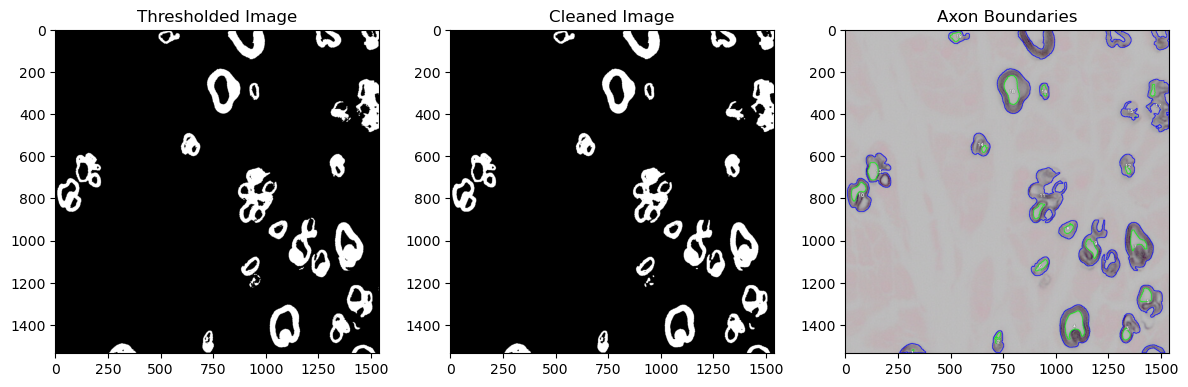


Axon 1:
  Center = (806.00, 1406.00)
  Outer Radius = 7.5293 µm
  Inner Radius = 5.2928 µm
  Thickness = 2.2365 µm
  Diameter = 15.0586 µm
  Outer Area = 119.8911 µm²
  Inner Area = 44.5384 µm²
  Area Ratio = 0.3715

Axon 2:
  Center = (57.00, 1200.00)
  Outer Radius = 11.9819 µm
  Inner Radius = 5.4919 µm
  Thickness = 6.4900 µm
  Diameter = 23.9638 µm
  Outer Area = 292.1813 µm²
  Inner Area = 52.3437 µm²
  Area Ratio = 0.1791

Axon 3:
  Center = (1121.06, 1243.39)
  Outer Radius = 20.3064 µm
  Inner Radius = 7.9478 µm
  Thickness = 12.3587 µm
  Diameter = 40.6129 µm
  Outer Area = 542.5709 µm²
  Inner Area = 80.9015 µm²
  Area Ratio = 0.1491

Axon 4:
  Center = (592.24, 1157.81)
  Outer Radius = 17.4000 µm
  Inner Radius = 7.4552 µm
  Thickness = 9.9447 µm
  Diameter = 34.7999 µm
  Outer Area = 494.6755 µm²
  Inner Area = 76.1573 µm²
  Area Ratio = 0.1540

Axon 5:
  Center = (201.34, 1073.65)
  Outer Radius = 8.2409 µm
  Inner Radius = 4.1133 µm
  Thickness = 4.1276 µm
  Diameter =

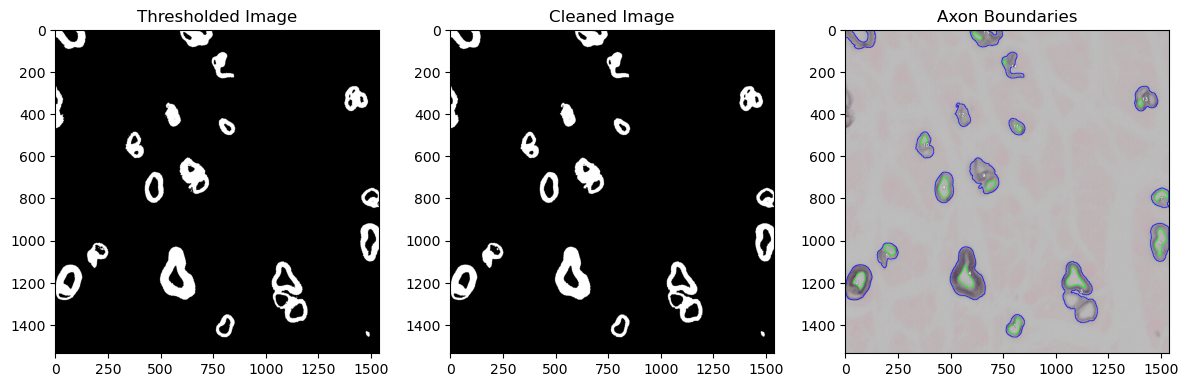


Axon 1:
  Center = (753.71, 1460.44)
  Outer Radius = 10.0423 µm
  Inner Radius = 3.5601 µm
  Thickness = 6.4821 µm
  Diameter = 20.0845 µm
  Outer Area = 168.2489 µm²
  Inner Area = 22.1212 µm²
  Area Ratio = 0.1315

Axon 2:
  Center = (449.61, 1368.62)
  Outer Radius = 9.5614 µm
  Inner Radius = 5.0159 µm
  Thickness = 4.5455 µm
  Diameter = 19.1228 µm
  Outer Area = 221.3139 µm²
  Inner Area = 48.4318 µm²
  Area Ratio = 0.2188

Axon 3:
  Center = (224.31, 1309.67)
  Outer Radius = 6.2676 µm
  Inner Radius = 3.8135 µm
  Thickness = 2.4542 µm
  Diameter = 12.5353 µm
  Outer Area = 89.6871 µm²
  Inner Area = 22.2969 µm²
  Area Ratio = 0.2486

Axon 4:
  Center = (1097.50, 1227.50)
  Outer Radius = 13.5048 µm
  Inner Radius = 2.2233 µm
  Thickness = 11.2815 µm
  Diameter = 27.0096 µm
  Outer Area = 201.7174 µm²
  Inner Area = 5.3916 µm²
  Area Ratio = 0.0267

Axon 5:
  Center = (757.27, 1198.05)
  Outer Radius = 19.5747 µm
  Inner Radius = 12.8136 µm
  Thickness = 6.7611 µm
  Diameter =

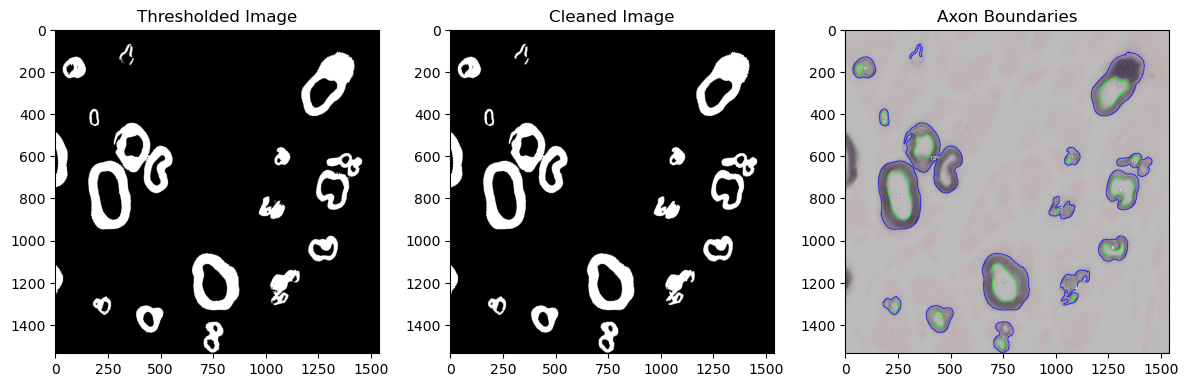


Axon 1:
  Center = (977.44, 1313.61)
  Outer Radius = 8.9049 µm
  Inner Radius = 1.0358 µm
  Thickness = 7.8692 µm
  Diameter = 17.8098 µm
  Outer Area = 180.6319 µm²
  Inner Area = 2.2010 µm²
  Area Ratio = 0.0122

Axon 2:
  Center = (1002.17, 1140.57)
  Outer Radius = 6.9575 µm
  Inner Radius = 2.8013 µm
  Thickness = 4.1563 µm
  Diameter = 13.9150 µm
  Outer Area = 110.1992 µm²
  Inner Area = 10.8756 µm²
  Area Ratio = 0.0987

Axon 3:
  Center = (328.50, 1030.54)
  Outer Radius = 8.1954 µm
  Inner Radius = 3.6241 µm
  Thickness = 4.5713 µm
  Diameter = 16.3908 µm
  Outer Area = 152.6290 µm²
  Inner Area = 24.6644 µm²
  Area Ratio = 0.1616

Axon 4:
  Center = (850.22, 938.08)
  Outer Radius = 10.4008 µm
  Inner Radius = 4.3361 µm
  Thickness = 6.0647 µm
  Diameter = 20.8016 µm
  Outer Area = 202.8364 µm²
  Inner Area = 18.5515 µm²
  Area Ratio = 0.0915

Axon 5:
  Center = (604.08, 912.41)
  Outer Radius = 8.0353 µm
  Inner Radius = 2.9248 µm
  Thickness = 5.1105 µm
  Diameter = 16.0

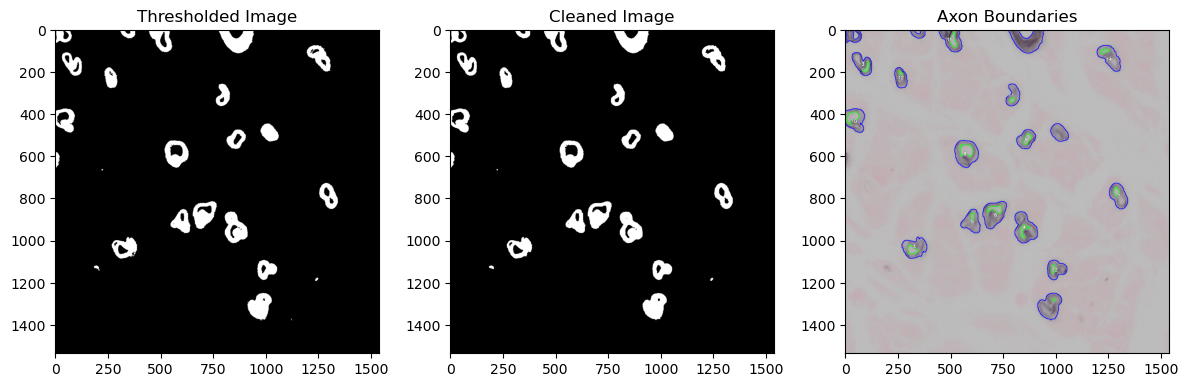


Axon 1:
  Center = (1368.50, 1339.50)
  Outer Radius = 11.2581 µm
  Inner Radius = 5.5632 µm
  Thickness = 5.6948 µm
  Diameter = 22.5161 µm
  Outer Area = 284.9309 µm²
  Inner Area = 73.2996 µm²
  Area Ratio = 0.2573

Axon 2:
  Center = (1036.07, 1311.68)
  Outer Radius = 11.5320 µm
  Inner Radius = 8.1635 µm
  Thickness = 3.3685 µm
  Diameter = 23.0640 µm
  Outer Area = 265.4916 µm²
  Inner Area = 77.0543 µm²
  Area Ratio = 0.2902

Axon 3:
  Center = (1153.00, 1218.00)
  Outer Radius = 7.1371 µm
  Inner Radius = 4.6983 µm
  Thickness = 2.4388 µm
  Diameter = 14.2742 µm
  Outer Area = 110.5598 µm²
  Inner Area = 37.5839 µm²
  Area Ratio = 0.3399

Axon 4:
  Center = (708.50, 1264.50)
  Outer Radius = 11.5948 µm
  Inner Radius = 8.5488 µm
  Thickness = 3.0459 µm
  Diameter = 23.1895 µm
  Outer Area = 290.8496 µm²
  Inner Area = 103.0875 µm²
  Area Ratio = 0.3544

Axon 5:
  Center = (326.85, 1137.66)
  Outer Radius = 7.9656 µm
  Inner Radius = 5.6869 µm
  Thickness = 2.2788 µm
  Diamete

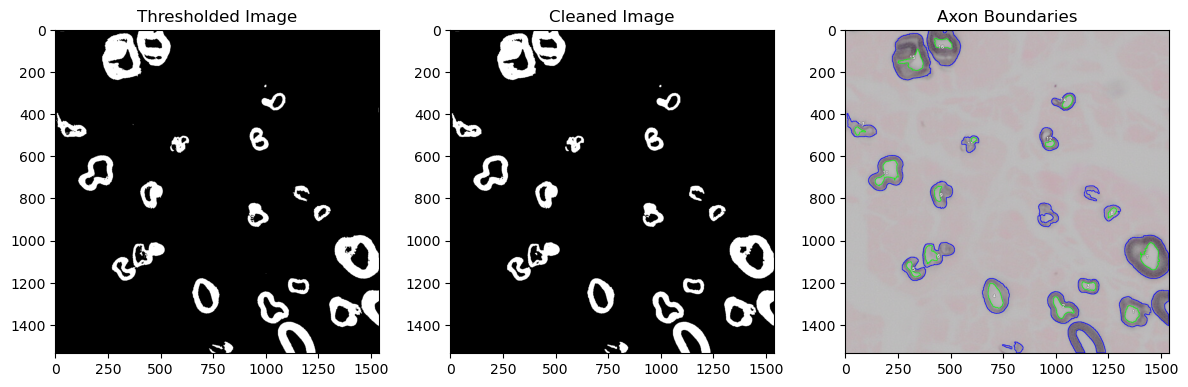


Axon 1:
  Center = (1105.67, 1364.10)
  Outer Radius = 7.3992 µm
  Inner Radius = 2.9874 µm
  Thickness = 4.4118 µm
  Diameter = 14.7983 µm
  Outer Area = 86.7000 µm²
  Inner Area = 9.5994 µm²
  Area Ratio = 0.1107

Axon 2:
  Center = (186.50, 1325.00)
  Outer Radius = 6.3619 µm
  Inner Radius = 3.3878 µm
  Thickness = 2.9742 µm
  Diameter = 12.7238 µm
  Outer Area = 93.6637 µm²
  Inner Area = 20.2901 µm²
  Area Ratio = 0.2166

Axon 3:
  Center = (619.00, 1346.00)
  Outer Radius = 16.5926 µm
  Inner Radius = 9.9480 µm
  Thickness = 6.6446 µm
  Diameter = 33.1851 µm
  Outer Area = 465.0819 µm²
  Inner Area = 176.4333 µm²
  Area Ratio = 0.3794

Axon 4:
  Center = (8.00, 1232.00)
  Outer Radius = 7.6933 µm
  Inner Radius = 0.1360 µm
  Thickness = 7.5573 µm
  Diameter = 15.3867 µm
  Outer Area = 50.1519 µm²
  Inner Area = 0.0370 µm²
  Area Ratio = 0.0007

Axon 5:
  Center = (555.00, 1110.82)
  Outer Radius = 8.9257 µm
  Inner Radius = 2.8822 µm
  Thickness = 6.0435 µm
  Diameter = 17.8515

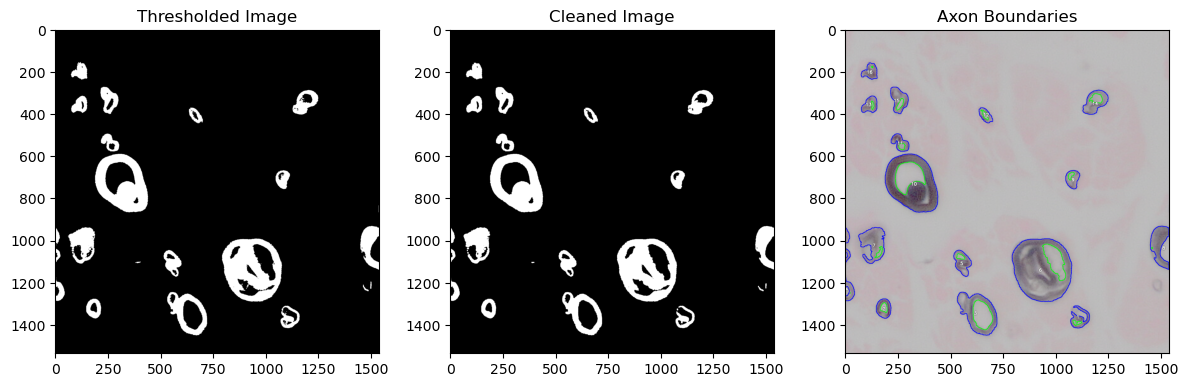


Axon 1:
  Center = (195.50, 1182.50)
  Outer Radius = 15.4434 µm
  Inner Radius = 10.7997 µm
  Thickness = 4.6436 µm
  Diameter = 30.8867 µm
  Outer Area = 496.9875 µm²
  Inner Area = 213.2589 µm²
  Area Ratio = 0.4291

Axon 2:
  Center = (13.00, 1043.50)
  Outer Radius = 13.6470 µm
  Inner Radius = 1.1215 µm
  Thickness = 12.5255 µm
  Diameter = 27.2940 µm
  Outer Area = 136.7872 µm²
  Inner Area = 1.2855 µm²
  Area Ratio = 0.0094

Axon 3:
  Center = (1341.28, 943.38)
  Outer Radius = 9.2336 µm
  Inner Radius = 5.2902 µm
  Thickness = 3.9435 µm
  Diameter = 18.4673 µm
  Outer Area = 177.1269 µm²
  Inner Area = 27.1891 µm²
  Area Ratio = 0.1535

Axon 4:
  Center = (111.50, 881.00)
  Outer Radius = 18.1295 µm
  Inner Radius = 13.3282 µm
  Thickness = 4.8013 µm
  Diameter = 36.2590 µm
  Outer Area = 637.8623 µm²
  Inner Area = 243.8883 µm²
  Area Ratio = 0.3824

Axon 5:
  Center = (776.50, 639.00)
  Outer Radius = 7.9931 µm
  Inner Radius = 3.3679 µm
  Thickness = 4.6252 µm
  Diameter =

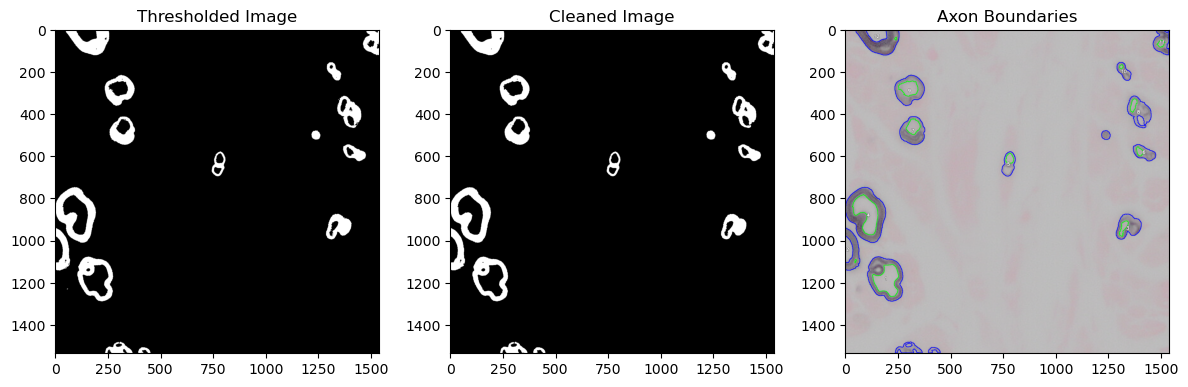


Axon 1:
  Center = (415.12, 1431.42)
  Outer Radius = 5.9098 µm
  Inner Radius = 3.6047 µm
  Thickness = 2.3051 µm
  Diameter = 11.8196 µm
  Outer Area = 61.9616 µm²
  Inner Area = 17.2568 µm²
  Area Ratio = 0.2785

Axon 2:
  Center = (277.50, 1449.50)
  Outer Radius = 11.6171 µm
  Inner Radius = 4.1307 µm
  Thickness = 7.4864 µm
  Diameter = 23.2341 µm
  Outer Area = 233.4473 µm²
  Inner Area = 29.7601 µm²
  Area Ratio = 0.1275

Axon 3:
  Center = (766.90, 1202.10)
  Outer Radius = 7.2390 µm
  Inner Radius = 3.5005 µm
  Thickness = 3.7385 µm
  Diameter = 14.4780 µm
  Outer Area = 124.6076 µm²
  Inner Area = 12.1519 µm²
  Area Ratio = 0.0975

Axon 4:
  Center = (1406.50, 1050.77)
  Outer Radius = 8.4108 µm
  Inner Radius = 2.1148 µm
  Thickness = 6.2960 µm
  Diameter = 16.8216 µm
  Outer Area = 155.9398 µm²
  Inner Area = 7.3059 µm²
  Area Ratio = 0.0469

Axon 5:
  Center = (117.00, 943.72)
  Outer Radius = 8.8586 µm
  Inner Radius = 4.4736 µm
  Thickness = 4.3850 µm
  Diameter = 17.7

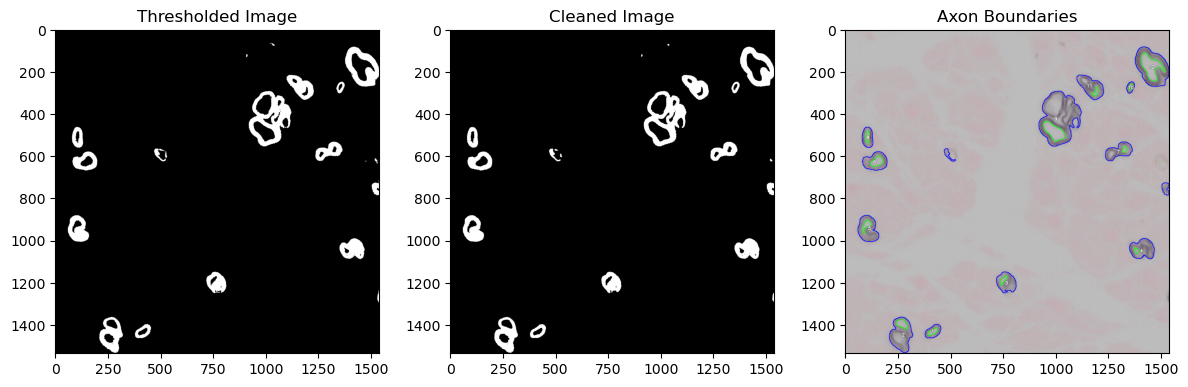


Axon 1:
  Center = (866.50, 1436.50)
  Outer Radius = 22.6727 µm
  Inner Radius = 8.6636 µm
  Thickness = 14.0091 µm
  Diameter = 45.3454 µm
  Outer Area = 589.3380 µm²
  Inner Area = 150.0396 µm²
  Area Ratio = 0.2546

Axon 2:
  Center = (1271.10, 1369.30)
  Outer Radius = 8.4235 µm
  Inner Radius = 1.6113 µm
  Thickness = 6.8122 µm
  Diameter = 16.8471 µm
  Outer Area = 145.4988 µm²
  Inner Area = 5.1789 µm²
  Area Ratio = 0.0356

Axon 3:
  Center = (464.59, 1275.20)
  Outer Radius = 8.0443 µm
  Inner Radius = 3.4972 µm
  Thickness = 4.5470 µm
  Diameter = 16.0885 µm
  Outer Area = 118.0415 µm²
  Inner Area = 24.5997 µm²
  Area Ratio = 0.2084

Axon 4:
  Center = (292.50, 1191.50)
  Outer Radius = 9.6383 µm
  Inner Radius = 4.0325 µm
  Thickness = 5.6058 µm
  Diameter = 19.2766 µm
  Outer Area = 164.4942 µm²
  Inner Area = 25.2470 µm²
  Area Ratio = 0.1535

Axon 5:
  Center = (1130.63, 1012.67)
  Outer Radius = 6.0905 µm
  Inner Radius = 4.9031 µm
  Thickness = 1.1874 µm
  Diameter =

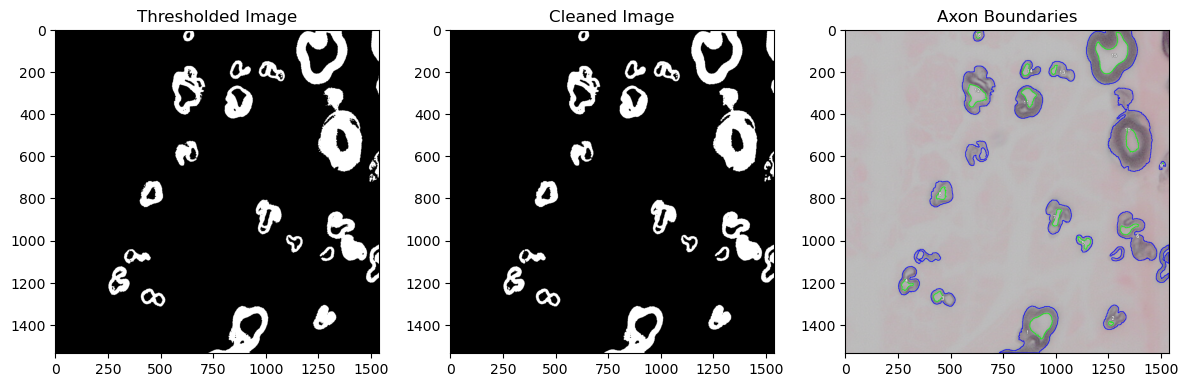


Axon 1:
  Center = (182.00, 1405.00)
  Outer Radius = 17.6486 µm
  Inner Radius = 12.1311 µm
  Thickness = 5.5175 µm
  Diameter = 35.2972 µm
  Outer Area = 681.5129 µm²
  Inner Area = 221.9058 µm²
  Area Ratio = 0.3256

Axon 2:
  Center = (23.33, 1183.55)
  Outer Radius = 4.0285 µm
  Inner Radius = 2.6160 µm
  Thickness = 1.4125 µm
  Diameter = 8.0571 µm
  Outer Area = 39.1930 µm²
  Inner Area = 13.2801 µm²
  Area Ratio = 0.3388

Axon 3:
  Center = (405.25, 1247.25)
  Outer Radius = 17.2626 µm
  Inner Radius = 11.8790 µm
  Thickness = 5.3836 µm
  Diameter = 34.5252 µm
  Outer Area = 444.4959 µm²
  Inner Area = 114.2960 µm²
  Area Ratio = 0.2571

Axon 4:
  Center = (608.00, 1070.00)
  Outer Radius = 4.3541 µm
  Inner Radius = 3.0449 µm
  Thickness = 1.3092 µm
  Diameter = 8.7083 µm
  Outer Area = 44.4736 µm²
  Inner Area = 20.1329 µm²
  Area Ratio = 0.4527

Axon 5:
  Center = (1290.00, 990.00)
  Outer Radius = 20.3000 µm
  Inner Radius = 10.5840 µm
  Thickness = 9.7160 µm
  Diameter = 

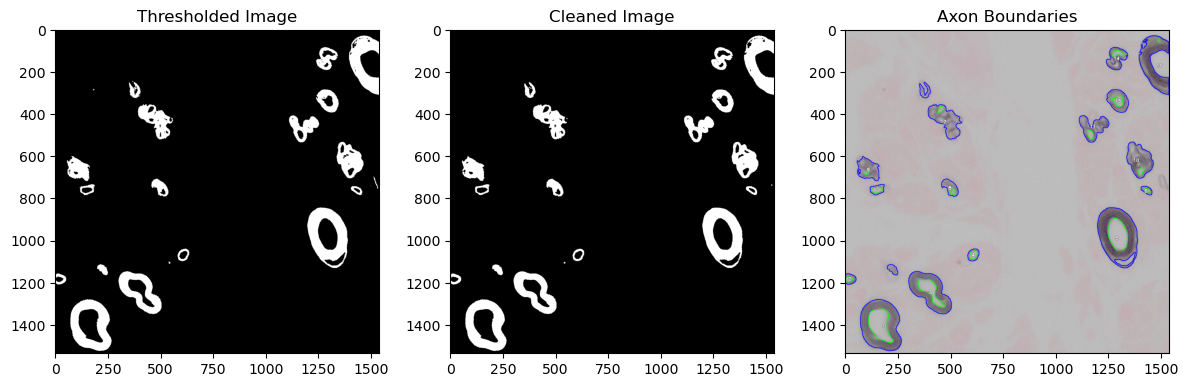


Axon 1:
  Center = (414.28, 1409.39)
  Outer Radius = 19.4725 µm
  Inner Radius = 7.8340 µm
  Thickness = 11.6385 µm
  Diameter = 38.9451 µm
  Outer Area = 976.2651 µm²
  Inner Area = 105.1313 µm²
  Area Ratio = 0.1077

Axon 2:
  Center = (995.94, 1268.82)
  Outer Radius = 8.5858 µm
  Inner Radius = 2.7258 µm
  Thickness = 5.8600 µm
  Diameter = 17.1717 µm
  Outer Area = 161.8770 µm²
  Inner Area = 13.6131 µm²
  Area Ratio = 0.0841

Axon 3:
  Center = (415.54, 1185.07)
  Outer Radius = 11.2915 µm
  Inner Radius = 7.6849 µm
  Thickness = 3.6066 µm
  Diameter = 22.5830 µm
  Outer Area = 296.9718 µm²
  Inner Area = 95.4209 µm²
  Area Ratio = 0.3213

Axon 4:
  Center = (826.50, 1013.50)
  Outer Radius = 5.1222 µm
  Inner Radius = 0.5608 µm
  Thickness = 4.5614 µm
  Diameter = 10.2444 µm
  Outer Area = 37.3989 µm²
  Inner Area = 0.5179 µm²
  Area Ratio = 0.0138

Axon 5:
  Center = (486.84, 935.29)
  Outer Radius = 8.7932 µm
  Inner Radius = 3.5326 µm
  Thickness = 5.2606 µm
  Diameter = 17

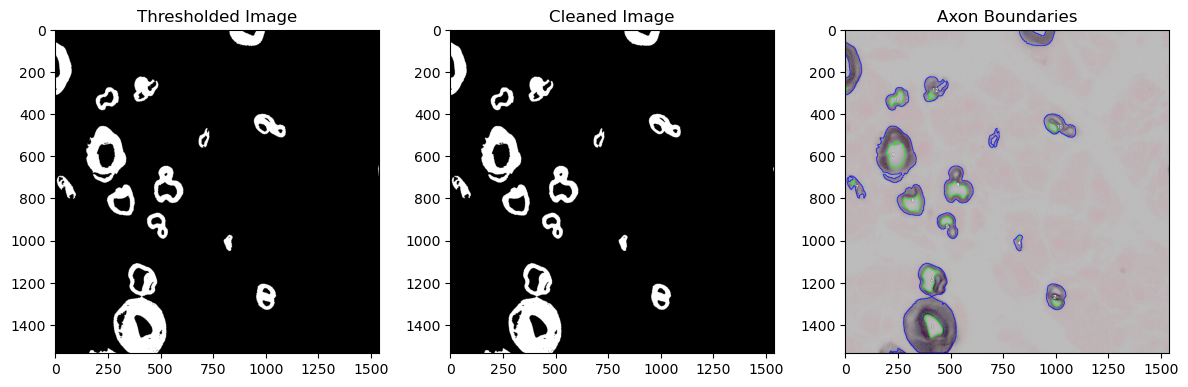


Axon 1:
  Center = (262.50, 1234.00)
  Outer Radius = 18.9510 µm
  Inner Radius = 5.9094 µm
  Thickness = 13.0416 µm
  Diameter = 37.9021 µm
  Outer Area = 480.5261 µm²
  Inner Area = 72.3933 µm²
  Area Ratio = 0.1507

Axon 2:
  Center = (759.23, 1102.50)
  Outer Radius = 9.3014 µm
  Inner Radius = 3.7122 µm
  Thickness = 5.5892 µm
  Diameter = 18.6028 µm
  Outer Area = 187.8269 µm²
  Inner Area = 25.7649 µm²
  Area Ratio = 0.1372

Axon 3:
  Center = (461.95, 1039.05)
  Outer Radius = 7.8201 µm
  Inner Radius = 4.5302 µm
  Thickness = 3.2900 µm
  Diameter = 15.6403 µm
  Outer Area = 129.3980 µm²
  Inner Area = 23.2217 µm²
  Area Ratio = 0.1795

Axon 4:
  Center = (1100.65, 876.90)
  Outer Radius = 9.1728 µm
  Inner Radius = 6.8000 µm
  Thickness = 2.3728 µm
  Diameter = 18.3457 µm
  Outer Area = 132.7180 µm²
  Inner Area = 37.3619 µm²
  Area Ratio = 0.2815

Axon 5:
  Center = (516.00, 737.00)
  Outer Radius = 9.2049 µm
  Inner Radius = 0.2859 µm
  Thickness = 8.9190 µm
  Diameter = 18

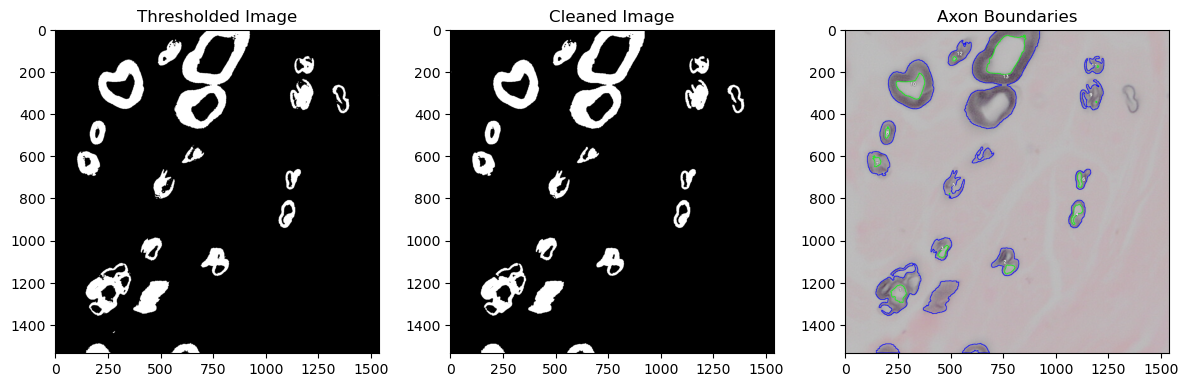


✅ All images processed and saved to 'C:\Users\sanje\Downloads\general_patches'


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

# Input and output paths for folder
input_folder = r'C:\Users\sanje\Downloads\patches_processed'
output_folder = r"C:\Users\sanje\Downloads\general_patches"
os.makedirs(output_folder, exist_ok=True)

# Scale factor (pixels to micrometers)
scale_factor = 0.136

def darken_and_sharpen(image):
    darkened = cv2.convertScaleAbs(image, alpha=1.1, beta=-10)
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    return cv2.filter2D(darkened, -1, sharpen_kernel)

def filter_dark_regions(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    dark_mask = cv2.inRange(L, 0, 250)
    return cv2.bitwise_and(image, image, mask=dark_mask)

def process_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = darken_and_sharpen(image)
    image = filter_dark_regions(image)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    contours, hierarchy = cv2.findContours(cleaned, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    axon_data = []
    object_counter = 1
    min_contour_area = 320
    output_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area < min_contour_area:
            continue

        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h if h != 0 else 0
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area if hull_area != 0 else 0

        if aspect_ratio < 0.3 or aspect_ratio > 3.5 or solidity < 0.5:
            continue

        if hierarchy[0][i][3] == -1:
            (x_outer, y_outer), outer_radius = cv2.minEnclosingCircle(contour)
            cv2.drawContours(output_image, [contour], -1, (255, 0, 0), 2)

            largest_inner_contour = None
            max_inner_area = 0
            inner_radius = 0

            for j, inner_contour in enumerate(contours):
                if hierarchy[0][j][3] == i:
                    area = cv2.contourArea(inner_contour)
                    if area > max_inner_area:
                        max_inner_area = area
                        largest_inner_contour = inner_contour
                        (x_inner, y_inner), inner_radius = cv2.minEnclosingCircle(inner_contour)

            if largest_inner_contour is not None:
                cv2.drawContours(output_image, [largest_inner_contour], -1, (0, 255, 0), 2)

                outer_area_px = cv2.contourArea(contour)
                inner_area_px = cv2.contourArea(largest_inner_contour)
                outer_area_um2 = outer_area_px * (scale_factor ** 2)
                inner_area_um2 = inner_area_px * (scale_factor ** 2)
                area_ratio = inner_area_um2 / outer_area_um2 if outer_area_um2 != 0 else 0

                axon_data.append({
                    "axon_id": object_counter,
                    "outer_radius": outer_radius * scale_factor,
                    "inner_radius": inner_radius * scale_factor,
                    "thickness": (outer_radius - inner_radius) * scale_factor,
                    "diameter": (2 * outer_radius) * scale_factor,
                    "center": (x_outer, y_outer),
                    "outer_area": outer_area_um2,
                    "inner_area": inner_area_um2,
                    "area_ratio": area_ratio
                })

                # ✅ Print the axon data in desired format
                print(f"\nAxon {object_counter}:")
                print(f"  Center = ({x_outer:.2f}, {y_outer:.2f})")
                print(f"  Outer Radius = {outer_radius * scale_factor:.4f} µm")
                print(f"  Inner Radius = {inner_radius * scale_factor:.4f} µm")
                print(f"  Thickness = {(outer_radius - inner_radius) * scale_factor:.4f} µm")
                print(f"  Diameter = {(2 * outer_radius) * scale_factor:.4f} µm")
                print(f"  Outer Area = {outer_area_um2:.4f} µm²")
                print(f"  Inner Area = {inner_area_um2:.4f} µm²")
                print(f"  Area Ratio = {area_ratio:.4f}")

                text = str(object_counter)
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.7
                thickness = 2
                (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, thickness)
                text_x = int(x_outer - text_width / 2)
                text_y = int(y_outer + text_height / 2)

                cv2.putText(output_image, text, (text_x, text_y), font, font_scale, (0, 0, 0), thickness + 2, cv2.LINE_AA)
                cv2.putText(output_image, text, (text_x, text_y), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

                object_counter += 1

    filename = os.path.basename(image_path)
    output_path = os.path.join(output_folder, f"processed_{filename}")
    cv2.imwrite(output_path, output_image)

    print(f"\n✅ Processed: {filename}")
    print(f"Axons detected: {len(axon_data)}")

    return thresh, cleaned, output_image

# Loop through all PNG images in the input folder
image_paths = glob(os.path.join(input_folder, "*.png"))

for image_path in image_paths:
    thresh, cleaned, output_image = process_image(image_path)

    # Optional visualization
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Thresholded Image")
    plt.imshow(thresh, cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("Cleaned Image")
    plt.imshow(cleaned, cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Axon Boundaries")
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

    plt.tight_layout()
    plt.show()

print(f"\n✅ All images processed and saved to '{output_folder}'")

#Preprocesses axon images (darkening, sharpening, CLAHE, etc.)
#Detects axons using contours with inner & outer boundaries.
#Filters by area, aspect ratio, and solidity.
#Calculates outer/inner radius, thickness, diameter, area, and area ratio.
#Draws contours and IDs on the image.
#Saves output and displays thresholded, cleaned, and final images.



In [ ]:
#the 1st code takes in an image and sharpens and darkens it , converts into "lab" color space for better understanding and then does some processing 
#and give the reqd output of that complete image with the reqd data needed and saves the output imnage into a folder.

#The 2nd code almost does the same thing but this code takes a folder of images preprocesses it like oin the before code(lab color space, darken and sharpen)
#proccesses all the images then(clahe+ostu+gaussian blur) and gives the output, in this output u can see the data as well as their repective graphs of the metrics against frequnecy
#this code also prints the folder's global statistics and the global grpahs too.

#the 3rd code does the exact same thing as that of the 2nd code just without the graphs